In [ ]:
# Ensure repo and src/ are importable and .env is loaded
import notebooks._bootstrap_src_path  # noqa: F401


In [ ]:
# Dependencies are managed via the repository's virtual environment.
# Install once from the project root using `requirements.txt`.
# This notebook intentionally avoids `%pip install` lines.

Note: you may need to restart the kernel to use updated packages.


In [10]:
BASIC_RAG_COLOR = "#1f77b4"

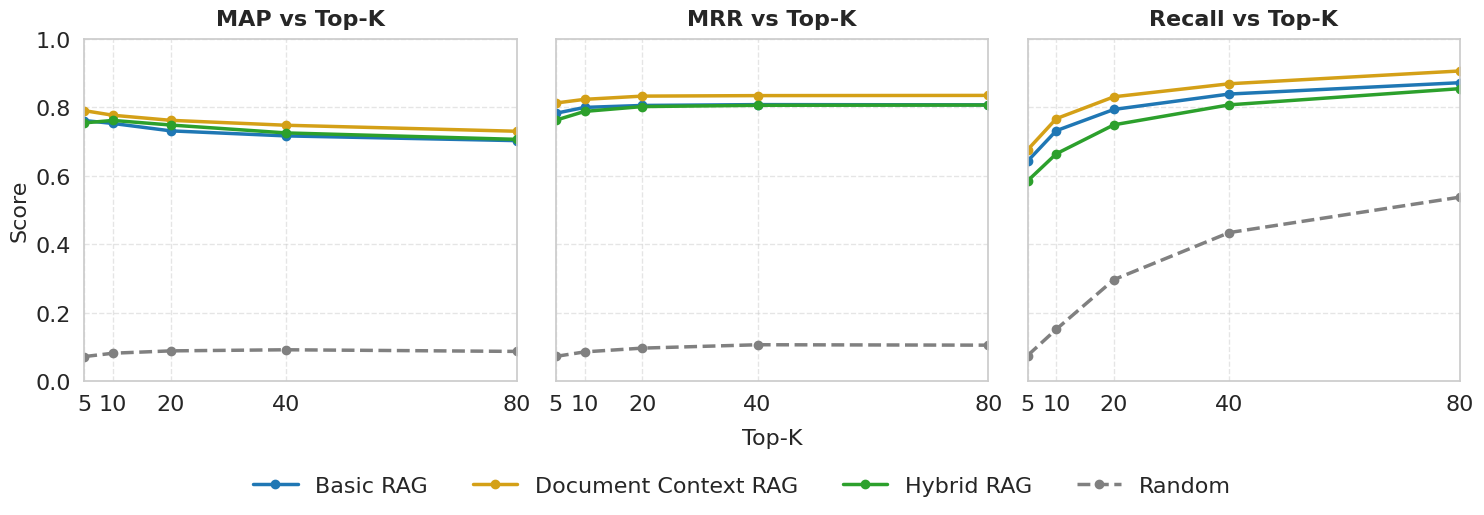

In [1]:
import os
import glob
import re
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# ─── CONFIG ────────────────────────────────────────────────────────────────────
BASE_DIR        = "results/retrieval/2025-07-30_09-27-44/QwenQwen3-Embedding-8B"
PATTERN         = os.path.join(BASE_DIR, "docs_*", "topk_*.pkl")
METRICS         = ["map", "mrr", "recall"]
DESIRED_TOPKS   = [5, 10, 20, 40, 80]  # only show these ticks if present
CANON_LEGEND_ORDER = ["basic", "contextual", "hybrid", "random"]  # random last
FONT_SIZE = 16
# ─── END CONFIG ────────────────────────────────────────────────────────────────

# Canonical colors & styles (match chunk size chart below)
COLOR_MAP = {
    "basic":      BASIC_RAG_COLOR,  # blue
    "contextual": "#d4a017",  # gold
    "hybrid":     "#2ca02c",  # green
    "random":     "gray",      # baseline
}
STYLE_MAP = {
    "basic":      "-",
    "contextual": "-",
    "hybrid":     "-",
    "random":     "--",        # dashed baseline
}

# ─────────────────────────── LOAD & PREP ──────────────────────────
def mean_col(s: pd.Series) -> float:
    clean = (
        s.dropna()
         .apply(lambda x: x[0] if isinstance(x, (list, tuple)) and len(x) == 1 else x)
         .astype(float)
    )
    return float(clean.mean()) if not clean.empty else np.nan

def canon_rag(name: str) -> str:
    n = (name or "").lower()
    if "random" in n: return "random"
    if "hybrid" in n: return "hybrid"
    if "context" in n: return "contextual"
    if "basic" in n or "base" in n or "retriever_only" in n: return "basic"
    return n  # fallback

records = []
for fp in glob.glob(PATTERN):
    splitting = os.path.basename(os.path.dirname(fp)).removeprefix("docs_")
    m = re.search(r"topk_(\d+)\.pkl$", fp)
    if not m:
        continue
    topk = int(m.group(1))
    try:
        df = pd.read_pickle(fp)
    except Exception as e:
        print(f"[warn] Failed to read {fp}: {e}")
        continue

    prefixes = {
        col.rsplit("_", 1)[0]
        for col in df.columns
        if any(col.endswith(f"_{mx}") for mx in METRICS)
    }
    prefixes = sorted(
        p for p in prefixes
        if all(f"{p}_{mx}" in df.columns for mx in METRICS)
    )

    for p in prefixes:
        for metric in METRICS:
            col = f"{p}_{metric}"
            score = mean_col(df[col]) if col in df.columns else np.nan
            records.append({
                "splitting": splitting,
                "topk"     : topk,
                "rag_type" : p,
                "rag_type_canon": canon_rag(p),
                "metric"   : metric,
                "score"    : score
            })

results = pd.DataFrame.from_records(
    records, columns=["splitting","topk","rag_type","rag_type_canon","metric","score"]
)

results = results.dropna(subset=["score"])
if results.empty:
    print("[info] No valid scores to plot.")

# ─────────── COMBINE ACROSS *ALL* CHUNKING STRATEGIES ────────────
combined = (
    results
    .groupby(["rag_type","rag_type_canon", "metric", "topk"], as_index=False)["score"]
    .mean()
)

# ───────────────────────── LINE STYLES / COLORS ───────────────────
rag_types = sorted(combined["rag_type"].unique())
# Order: random last now
ordered_rag_types = sorted(rag_types, key=lambda x: (1 if "random" in x.lower() else 0, x.lower()))

rag_colors = {}
rag_styles = {}
for rt in ordered_rag_types:
    canon = canon_rag(rt)
    rag_colors[rt] = COLOR_MAP.get(canon, "#444444")
    rag_styles[rt] = STYLE_MAP.get(canon, "-")

topks = sorted(combined["topk"].unique())
existing_tick_topks = [tk for tk in DESIRED_TOPKS if tk in topks]

sns.set(style="whitegrid")

# ───────────────────── THREE CHARTS SIDE-BY-SIDE ─────────────────
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)
metric_titles = {"map": "MAP vs Top-K",
                 "mrr": "MRR vs Top-K",
                 "recall": "Recall vs Top-K"}

for ax, metric in zip(axes, METRICS):
    sub_m = combined[combined["metric"] == metric]
    for rt in ordered_rag_types:
        df_rt = sub_m[sub_m["rag_type"] == rt].sort_values("topk")
        if df_rt.empty:
            continue
        ax.plot(
            df_rt["topk"],
            df_rt["score"],
            linestyle=rag_styles.get(rt, "-"),
            linewidth=2.5,
            color=rag_colors[rt],
            marker="o",
            markersize=6,
            label=rt
        )
    ax.set_ylim(0.0, 1.0)
    if len(topks):
        ax.set_xlim(min(topks), max(topks))
    # Apply restricted tick labels
    if existing_tick_topks:
        ax.set_xticks(existing_tick_topks)
        ax.set_xticklabels([str(tk) for tk in existing_tick_topks], fontsize=FONT_SIZE)
    if metric == "mrr":
        ax.set_xlabel("Top-K", fontsize=FONT_SIZE, labelpad=10)
    ax.set_title(metric_titles[metric], fontsize=FONT_SIZE, fontweight="bold", pad=10)
    ax.tick_params(axis="both", which="major", labelsize=FONT_SIZE)
    ax.grid(True, linestyle="--", alpha=0.5)

axes[0].set_ylabel("Score", fontsize=FONT_SIZE)

# Place legend below all charts (deduplicate labels, enforce canonical order with random last)
handle_dict = {}
for ax in axes:
    h, l = ax.get_legend_handles_labels()
    for hh, ll in zip(h, l):
        if ll not in handle_dict:
            handle_dict[ll] = hh

# Map raw label -> canonical key
label_to_canon = {lbl: canon_rag(lbl) for lbl in handle_dict.keys()}
legend_labels_ordered = [
    lbl for canon in CANON_LEGEND_ORDER
    for lbl, c in label_to_canon.items() if c == canon
]
legend_handles_ordered = [handle_dict[lbl] for lbl in legend_labels_ordered]

fig.legend(
    handles=legend_handles_ordered,
    labels=legend_labels_ordered,
    title="",
    title_fontsize=FONT_SIZE,
    fontsize=FONT_SIZE,
    loc="lower center",
    ncol=min(4, len(legend_labels_ordered)),
    bbox_to_anchor=(0.5, -0.05),
    frameon=False,
)

plt.tight_layout(rect=[0, 0.05, 1, 1])
plt.show()

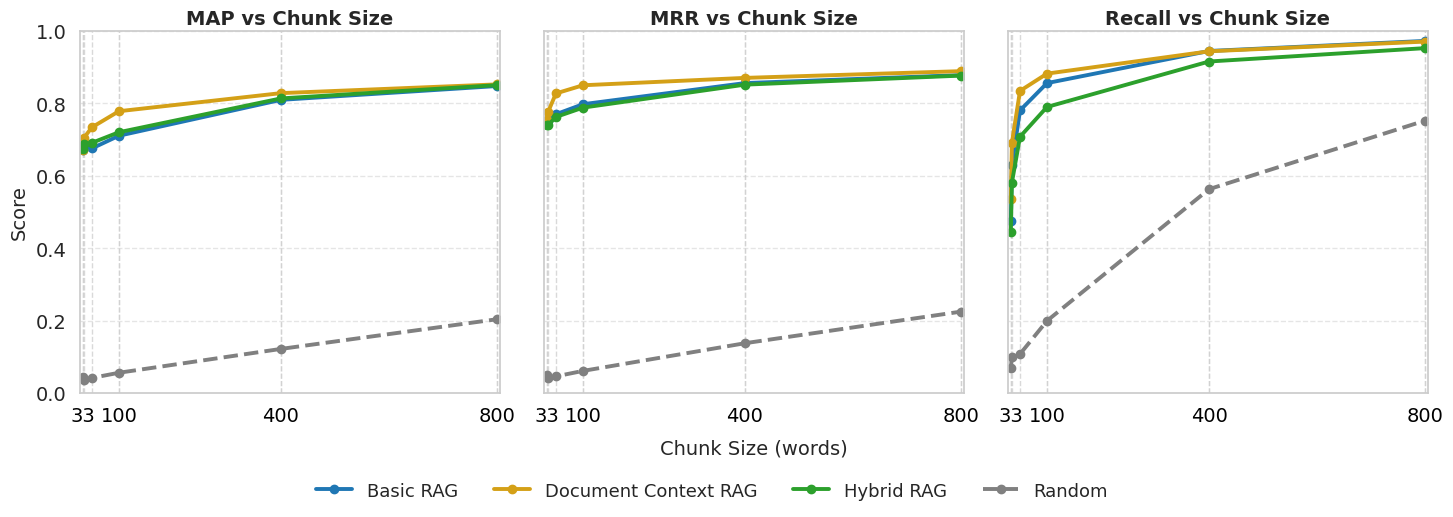

In [ ]:
import os
import glob
import re
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# ─── CONFIG ────────────────────────────────────────────────────────────────────
BASE_DIR        = "results/retrieval/2025-07-30_09-27-44/QwenQwen3-Embedding-8B"
PATTERN         = os.path.join(BASE_DIR, "docs_*", "topk_*.pkl")
METRICS         = ["map", "mrr", "recall"]

# Colors/styles for canonical RAG types
COLOR_MAP = {
    "basic":      "#1f77b4",  # blue
    "contextual": "#d4a017",  # gold
    "hybrid":     "#2ca02c",  # green
    "random":     "gray",      # baseline
}
STYLE_MAP = {
    "basic":      "-",
    "contextual": "-",
    "hybrid":     "-",
    "random":     "--",        # dashed baseline
}

# Average words for non-word chunkers
LINE_WORDS     = 33
PASSAGE_WORDS  = 35

# Desired legend order
PREFERRED_RAGS = ["basic", "contextual", "hybrid", "random"]
FONT_SIZE = 16
# ─── END CONFIG ────────────────────────────────────────────────────────────────

# ─────────────────────────── LOAD & PREP ──────────────────────────
def mean_col(s: pd.Series) -> float:
    clean = (
        s.dropna()
         .apply(lambda x: x[0] if isinstance(x, (list, tuple)) and len(x) == 1 else x)
         .astype(float)
    )
    return float(clean.mean()) if not clean.empty else np.nan

def chunk_size_from_splitting(s: str) -> float:
    """Return numeric chunk size in words for x-axis."""
    if not isinstance(s, str):
        return np.nan
    if s.startswith("line_"):
        return float(LINE_WORDS)
    if s.startswith("passage_"):
        return float(PASSAGE_WORDS)
    m = re.match(r"word_(\d+)", s)
    if m:
        return float(m.group(1))
    m2 = re.search(r"(\d+)", s)
    return float(m2.group(1)) if m2 else np.nan

def normalize_rag_name(name: str) -> str:
    """Map dataset-specific rag_type names to canonical keys."""
    n = (name or "").lower().strip()
    # common variants
    synonyms = {
        "basic": ["basic", "basic_rag", "rag_basic", "retriever_only", "base"],
        "contextual": ["contextual", "document_context", "document_context_rag",
                       "doc_context", "context", "contextual_rag"],
        "hybrid": ["hybrid", "hybrid_rag", "bm25+embed", "fusion", "colbert_hybrid"],
        "random": ["random", "random_rag", "baseline_random"],
    }
    for canon, alts in synonyms.items():
        if n == canon or n in alts:
            return canon
    # fuzzy contains
    if "random" in n:
        return "random"
    if "hybrid" in n:
        return "hybrid"
    if "context" in n:
        return "contextual"
    if "basic" in n or "base" in n or "retriever_only" in n:
        return "basic"
    return n  # fall back to original (will get default color)

# Gather records
records = []
for fp in glob.glob(PATTERN):
    splitting = os.path.basename(os.path.dirname(fp)).removeprefix("docs_")
    m = re.search(r"topk_(\d+)\.pkl$", fp)
    if not m:
        continue
    topk = int(m.group(1))
    try:
        df = pd.read_pickle(fp)
    except Exception as e:
        print(f"[warn] Failed to read {fp}: {e}")
        continue

    prefixes = {
        col.rsplit("_", 1)[0]
        for col in df.columns
        if any(col.endswith(f"_{mx}") for mx in METRICS)
    }
    prefixes = sorted(
        p for p in prefixes
        if all(f"{p}_{mx}" in df.columns for mx in METRICS)
    )

    for p in prefixes:
        for metric in METRICS:
            col = f"{p}_{metric}"
            score = mean_col(df[col]) if col in df.columns else np.nan
            records.append({
                "splitting": splitting,
                "chunk_size": chunk_size_from_splitting(splitting),
                "topk": topk,
                "rag_type_raw": p,
                "rag_type": normalize_rag_name(p),
                "metric": metric,
                "score": score,
            })

results = pd.DataFrame.from_records(records)

# Keep only valid rows
results = results.dropna(subset=["score", "chunk_size"])
if results.empty:
    print("[info] No valid scores to plot.")

# Average across all Top-K and any stride variants: one value per (rag_type, metric, chunk_size)
combined = (
    results.groupby(["rag_type", "metric", "chunk_size"], as_index=False)["score"].mean()
)

if combined.empty:
    print("[info] Nothing to plot after combining.")

# Which RAG types are present (preserve preferred order, then any extras)
present = list(combined["rag_type"].unique())
present_rags = [r for r in PREFERRED_RAGS if r in present] + sorted([r for r in present if r not in PREFERRED_RAGS])

# Ordered x sizes: ensure 33, 35, 50, 100, 400, 800 if present, then any others ascending
canonical = [LINE_WORDS, PASSAGE_WORDS, 50, 100, 400, 800]
present_sizes = sorted(combined["chunk_size"].unique())
ordered_sizes = [x for x in canonical if x in present_sizes] + [x for x in present_sizes if x not in canonical]

# ──────────────────────────── PLOTTING ────────────────────────────
sns.set(style="whitegrid")
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)

metric_titles = {
    "map": "MAP vs Chunk Size",
    "mrr": "MRR vs Chunk Size",
    "recall": "Recall vs Chunk Size",
}

for ax, metric in zip(axes, METRICS):
    sub_m = combined[combined["metric"] == metric]
    if sub_m.empty:
        continue

    # Lines by RAG (colored)
    for rt in present_rags:
        df_rt = sub_m[sub_m["rag_type"] == rt].sort_values("chunk_size")
        if df_rt.empty:
            continue
        ax.plot(
            df_rt["chunk_size"],
            df_rt["score"],
            linestyle=STYLE_MAP.get(rt, "-"),
            linewidth=2.8,
            color=COLOR_MAP.get(rt, "#444444"),
            marker="o",
            markersize=6,
            label=rt,
        )

    # Axis formatting
    if ordered_sizes:
        ax.set_xlim(min(ordered_sizes) - 5, max(ordered_sizes) + 5)
        tick_positions = [x for x in ordered_sizes if x in (LINE_WORDS, 100, 400, 800)]
        tick_labels    = [str(int(x)) for x in tick_positions]
        ax.set_xticks(tick_positions)
        ax.set_xticklabels(tick_labels, rotation=0, color="black", fontsize=FONT_SIZE)
        for x in [LINE_WORDS, PASSAGE_WORDS, 50, 100, 400, 800]:
            if x in present_sizes:
                ax.axvline(x=x, color="0.85", linewidth=1, linestyle="--", zorder=0)

    ax.set_ylim(0.0, 1.0)
    if metric == "mrr":
        ax.set_xlabel("Chunk Size (words)", fontsize=FONT_SIZE, labelpad=10)
    else:
        ax.set_xlabel("", fontsize=FONT_SIZE)
    ax.set_title(metric_titles[metric], fontsize=FONT_SIZE, fontweight="semibold", pad=10)
    ax.tick_params(axis="both", which="major", labelsize=FONT_SIZE)
    ax.grid(True, linestyle="--", alpha=0.5)

axes[0].set_ylabel("Score", fontsize=FONT_SIZE, labelpad=5)

# Build legend from all axes, keep preferred order
handle_dict = {}
for ax in axes:
    h, l = ax.get_legend_handles_labels()
    for handle, label in zip(h, l):
        if label not in handle_dict:
            handle_dict[label] = handle

legend_handles = [handle_dict[lbl] for lbl in present_rags if lbl in handle_dict]
legend_labels  = [lbl for lbl in present_rags if lbl in handle_dict]

if legend_handles:
    fig.legend(
        handles=legend_handles,
        labels=[{
            "basic": "Basic RAG",
            "contextual": "Document Context RAG",
            "hybrid": "Hybrid RAG",
            "random": "Random",
        }.get(lbl, lbl) for lbl in legend_labels],
        title="",
        title_fontsize=FONT_SIZE,
        fontsize=FONT_SIZE,
        loc="lower center",
        ncol=max(1, len(legend_handles)),
        bbox_to_anchor=(0.5, -0.05),
        frameon=False,
    )

plt.tight_layout(rect=[0.02, 0.03, 1, 1])
plt.show()

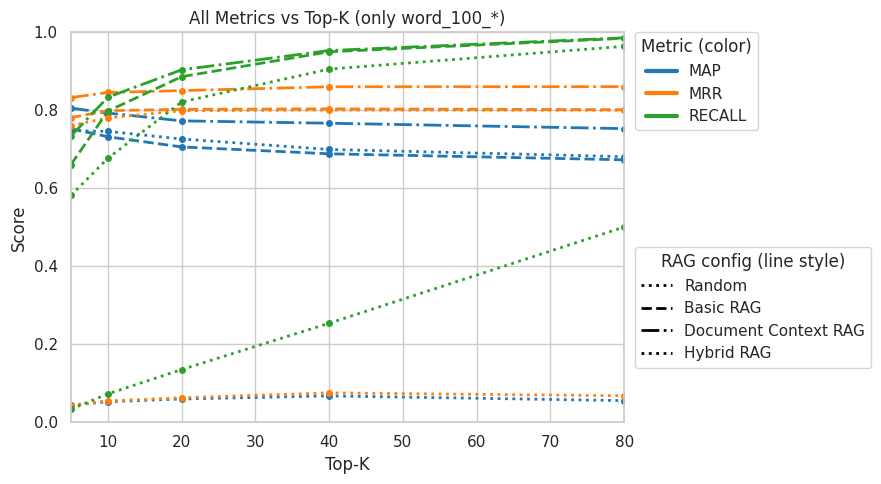

In [1]:
import os
import glob
import re
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# ─── CONFIG ────────────────────────────────────────────────────────────────────
BASE_DIR        = "results/retrieval/2025-07-30_09-27-44/QwenQwen3-Embedding-8B"
PATTERN         = os.path.join(BASE_DIR, "docs_*", "topk_*.pkl")
METRICS         = ["map", "mrr", "recall"]

# Only consider splittings that start with this prefix (e.g., word_100_*)
WORD_FILTER_PREFIX = "word_100_"
# ─── END CONFIG ────────────────────────────────────────────────────────────────


# ─────────────────────────── LOAD & PREP ──────────────────────────
def mean_col(s: pd.Series) -> float:
    clean = (
        s.dropna()
         .apply(lambda x: x[0] if isinstance(x, (list, tuple)) and len(x) == 1 else x)
         .astype(float)
    )
    return float(clean.mean()) if not clean.empty else np.nan

records = []
for fp in glob.glob(PATTERN):
    splitting = os.path.basename(os.path.dirname(fp)).removeprefix("docs_")
    m = re.search(r"topk_(\d+)\.pkl$", fp)
    if not m:
        continue
    topk = int(m.group(1))
    try:
        df = pd.read_pickle(fp)
    except Exception as e:
        print(f"[warn] Failed to read {fp}: {e}")
        continue

    prefixes = {
        col.rsplit("_", 1)[0]
        for col in df.columns
        if any(col.endswith(f"_{mx}") for mx in METRICS)
    }
    prefixes = sorted(
        p for p in prefixes
        if all(f"{p}_{mx}" in df.columns for mx in METRICS)
    )

    for p in prefixes:
        for metric in METRICS:
            col = f"{p}_{metric}"
            score = mean_col(df[col]) if col in df.columns else np.nan
            records.append({
                "splitting": splitting,
                "topk"     : topk,
                "rag_type" : p,
                "metric"   : metric,
                "score"    : score
            })

results = pd.DataFrame.from_records(
    records, columns=["splitting","topk","rag_type","metric","score"]
)

if results.empty:
    print("[info] No data parsed. Check BASE_DIR/PATTERN.")
    # import sys; sys.exit(0)

# keep only rows with scores
results = results.dropna(subset=["score"])
if results.empty:
    print("[info] No non-NaN scores. Nothing to plot.")
    # import sys; sys.exit(0)

# ─────────────────────── FILTER TO word_100_* ─────────────────────
word100 = results[results["splitting"].str.startswith(WORD_FILTER_PREFIX, na=False)].copy()
if word100.empty:
    print(f"[info] No rows matched splitting prefix '{WORD_FILTER_PREFIX}'.")
    # import sys; sys.exit(0)

# If there are multiple word_100_* variants (e.g., different stride values),
# average across them so we get ONE series per (rag_type, metric) over topk.
combined = (
    word100
    .groupby(["rag_type", "metric", "topk"], as_index=False)["score"]
    .mean()
)

# ───────────────────────── LINE STYLES / COLORS ───────────────────
rag_types = sorted(combined["rag_type"].unique())
# line style per rag config; "random" forced to dotted
base_styles = ["-", "--", "-.", ":", (0,(5,1,1,1)), (0,(3,1,1,1)), (0,(1,1))]
ordered_rag_types = sorted(rag_types, key=lambda x: (0 if "random" in x.lower() else 1, x))
style_map = {}
for i, rt in enumerate(ordered_rag_types):
    style_map[rt] = ":" if "random" in rt.lower() else base_styles[i % len(base_styles)]

# metric color map (same colors reused across charts)
metric_colors = {m: c for m, c in zip(METRICS, sns.color_palette(n_colors=len(METRICS)))}

topks = sorted(combined["topk"].unique())

sns.set(style="whitegrid")

# ─────────────── SINGLE CHART WITH ALL METRICS OVERLAID ───────────
# Color encodes METRIC; Line style encodes RAG CONFIG.
plt.figure(figsize=(9, 5))

for metric in METRICS:
    sub_m = combined[combined["metric"] == metric]
    for rt, df_rt in sub_m.groupby("rag_type", sort=False):
        df_rt = df_rt.sort_values("topk")
        plt.plot(
            df_rt["topk"],
            df_rt["score"],
            linestyle=style_map.get(rt, "-"),
            linewidth=2,
            color=metric_colors[metric],
            marker="o",
            markersize=4
        )

plt.ylim(0.0, 1.0)
if len(topks):
    plt.xlim(min(topks), max(topks))
plt.xlabel("Top-K")
plt.ylabel("Score")
plt.title(f"All Metrics vs Top-K (only {WORD_FILTER_PREFIX}*)")

# Build split legends: one for metric colors, one for rag styles
metric_handles = [Line2D([0],[0], color=metric_colors[m], lw=3, linestyle="-", label=m.upper())
                  for m in METRICS]
rag_handles = [Line2D([0],[0], color="black", lw=2, linestyle=style_map[rt], label=rt)
               for rt in ordered_rag_types]

leg1 = plt.legend(handles=metric_handles, title="Metric (color)",
                  bbox_to_anchor=(1.02, 1.0), loc="upper left", borderaxespad=0.)
plt.gca().add_artist(leg1)
plt.legend(handles=rag_handles, title="RAG config (line style)",
           bbox_to_anchor=(1.02, 0.45), loc="upper left", borderaxespad=0.)

plt.tight_layout()
plt.show()

Budgets with >=3 Recall combos: [2000.0, 4000.0, 8000.0]


/tmp/ipykernel_2042173/644050769.py:73: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(
/tmp/ipykernel_2042173/644050769.py:73: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(
/tmp/ipykernel_2042173/644050769.py:73: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(


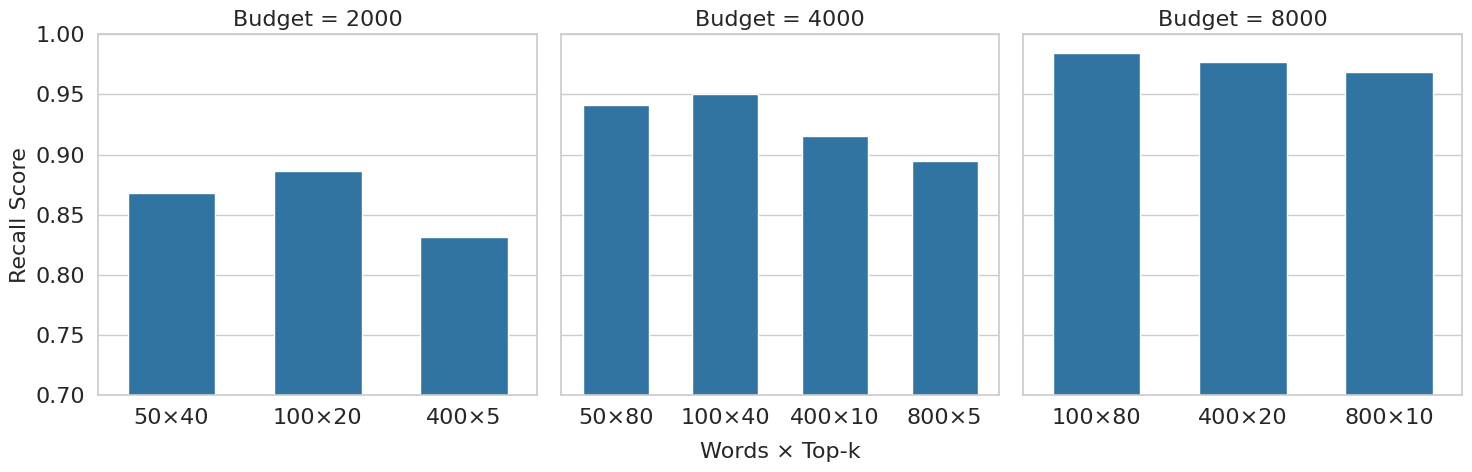

In [35]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Set all relevant font sizes to 16 for this cell's figures
plt.rcParams.update({
    "font.size": 16,
    "axes.titlesize": 16,
    "axes.labelsize": 16,
    "xtick.labelsize": 16,
    "ytick.labelsize": 16,
    "legend.fontsize": 16,
})

# Recall-only visualization for BASIC RAG:
# - Budgets with >=3 distinct (chunk_size, topk) combos
# - Bars colored with BASIC_RAG_COLOR
# - Uniform bar width across all subplots
# - X ticks shown for all remaining budgets
# - y-axis from 0.5 to 1.0
# - No legend

def parse_chunk_size(s: str):
    parts = s.split("_")
    if parts and parts[0].lower() == "word":
        try:
            return int(parts[1])
        except (IndexError, ValueError):
            return None
    return None

# 1) Derive chunk_size & budget
df = results.copy()
df["chunk_size"] = df["splitting"].apply(parse_chunk_size)
df["budget"] = df["chunk_size"] * df["topk"]

# 2) BASIC configs only
mask_basic = df["rag_type"].str.lower().str.contains("basic")
df_ctx = df[mask_basic & df["chunk_size"].notna()].copy()

# 3) Filter to Recall metric only
df_ctx = df_ctx[df_ctx["metric"].str.lower() == "recall"].copy()
if df_ctx.empty:
    print("No Recall data available for Basic RAG.")
else:
    df_ctx["combo_label"] = (
        df_ctx["chunk_size"].astype(int).astype(str) + "×" + df_ctx["topk"].astype(int).astype(str)
    )

    # 4) Compute combo counts per budget to filter >=3
    combo_counts = (
        df_ctx.drop_duplicates(subset=["budget", "chunk_size", "topk"])\
              .groupby("budget")["combo_label"].nunique()
    )
    valid_budgets = combo_counts[combo_counts >= 3].index.sort_values()
    print("Budgets with >=3 Recall combos:", list(valid_budgets))

    if len(valid_budgets) == 0:
        print("No budgets meet the >=3 combinations criterion (Recall only).")
    else:
        budgets_list = list(valid_budgets)
        n = len(budgets_list)

        fig, axes = plt.subplots(1, n, figsize=(15, 5), sharey=True)
        if n == 1:
            axes = [axes]

        BAR_WIDTH = 0.6  # uniform width applied to every bar

        for ax, budget in zip(axes, budgets_list):
            df_b = df_ctx[df_ctx["budget"] == budget].copy()
            order_labels = df_b.sort_values(["chunk_size", "topk"])["combo_label"].unique().tolist()
            sns.barplot(
                data=df_b,
                x="combo_label",
                y="score",
                order=order_labels,
                color=BASIC_RAG_COLOR,
                ci=None,
                ax=ax,
                width=BAR_WIDTH
            )
            ax.set_title(f"Budget = {int(budget)}")
            ax.set_ylim(0.7, 1.0)
            if budget == 4000:
                ax.set_xlabel("Words × Top-k", labelpad=10)
            else:
                ax.set_xlabel("")
            ax.tick_params(axis='x')
            if ax is axes[0]:
                ax.set_ylabel("Recall Score")
            else:
                ax.set_ylabel("")

        fig.tight_layout()
        plt.show()

Budgets with >=3 combinations: [2000.0, 4000.0, 8000.0]


/tmp/ipykernel_2042173/464559294.py:60: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(
/tmp/ipykernel_2042173/464559294.py:60: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(
/tmp/ipykernel_2042173/464559294.py:60: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(


Budgets with >=3 combinations: [2000.0, 4000.0, 8000.0]


/tmp/ipykernel_2042173/464559294.py:60: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(
/tmp/ipykernel_2042173/464559294.py:60: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(
/tmp/ipykernel_2042173/464559294.py:60: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(


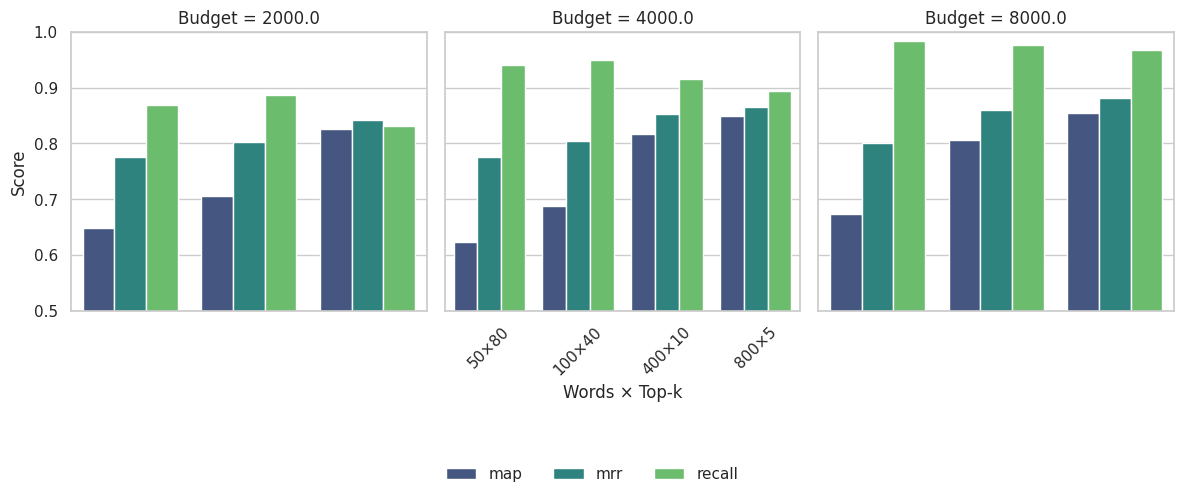

In [3]:
import glob
import os
import re
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

BASE_DIR = "results/retrieval/2025-07-30_09-27-44/QwenQwen3-Embedding-8B"
PATTERN = os.path.join(BASE_DIR, "docs_word_100_20", "topk_*.pkl")
COLOR = "#1f77b4"  # uniform color for all figures

all_dfs = []

for fp in glob.glob(PATTERN):
    print(f"Processing: {fp}")
    df = pd.read_pickle(fp)
    print("  Columns:", list(df.columns))
    
    basic_cols = [col for col in df.columns if col.startswith("Basic RAG_")]
    print("  Basic cols:", basic_cols)
    if not basic_cols:
        print("  Skipping (no Basic RAG metric columns).")
        continue
    if "variant" not in df.columns:
        print("  Skipping (no 'variant' column).")
        continue

    m = re.search(r"topk_(\d+)\.pkl$", fp)
    topk = int(m.group(1)) if m else None

    sub_df = df[basic_cols + ["variant"]].copy()
    sub_df["source_file"] = os.path.basename(fp)
    sub_df["topk"] = topk
    all_dfs.append(sub_df)

print(f"\n✅ Loaded {len(all_dfs)} DataFrames.")

if not all_dfs:
    print("❌ No data loaded. Check patterns.")
else:
    basic_data = pd.concat(all_dfs, ignore_index=True)
    print(f"✅ basic_data shape: {basic_data.shape}")

    melted = basic_data.melt(
        id_vars=["variant", "source_file", "topk"],
        var_name="metric",
        value_name="score"
    )
    melted["metric"] = melted["metric"].str.replace("Basic RAG_", "", regex=False)
    melted = melted.dropna(subset=["score", "topk"]).copy()
    print(melted.head())

# ------------------------------------------------------------------
# Figures (Recall, MAP, MRR) with full 0–1 score axis and Score label under Top-K 20
# Variant order forced to user-specified sequence.
# ------------------------------------------------------------------
if 'melted' in locals() and not melted.empty:
    sns.set(style="whitegrid")

    # New user-specified ordering
    user_order_labels = [
        "default", "contextual", "slang", "technical", "keyword", "short", "long", "mistake", "english", "turkish"
    ]

    def norm(s: str) -> str:
        return s.lower().strip().replace('-', ' ').replace('_',' ')

    existing_variants = list(melted['variant'].unique())
    norm_map = {}
    for v in existing_variants:
        norm_map.setdefault(norm(v), v)

    desired_variant_order = [norm_map[norm(lbl)] for lbl in user_order_labels if norm(lbl) in norm_map]
    missing = [lbl for lbl in user_order_labels if norm(lbl) not in norm_map]
    if missing:
        print(f"[info] Missing variants not found in data (skipped): {missing}")
    variant_order = desired_variant_order
    variant_label_map = {v: v.replace('_',' ').title() for v in variant_order}

    preferred_topk = [5,10,20,40,80]
    present_topk = sorted(melted['topk'].unique())
    topk_values = [k for k in preferred_topk if k in present_topk] + [k for k in present_topk if k not in preferred_topk]
    n_topk = len(topk_values)
    if n_topk == 0:
        print("No Top-K values found.")
    else:
        if 20 in topk_values:
            xlabel_topk = 20
        else:
            xlabel_topk = topk_values[len(topk_values)//2]
        per_variant_height = 0.50
        fig_height = max(5, per_variant_height * len(variant_order))
        fig_width = max(6, 3.0 * n_topk)
        xticks = [0.5, 0.75,1.0]

        def plot_single_metric(single_metric: str, title_prefix: str):
            if single_metric not in melted['metric'].unique():
                print(f"[skip] Metric '{single_metric}' not present.")
                return
            fig, axes = plt.subplots(1, n_topk, figsize=(fig_width, fig_height), sharey=True, constrained_layout=False)
            if n_topk == 1:
                axes = [axes]
            for ax, tk in zip(axes, topk_values):
                sub = melted[(melted['metric'] == single_metric) & (melted['topk'] == tk) & (melted['variant'].isin(variant_order))]
                if sub.empty:
                    ax.set_axis_off(); continue
                agg = (sub.groupby('variant')['score']
                          .mean()
                          .reindex(variant_order))
                y_pos = range(len(variant_order))
                ax.barh(list(y_pos), agg.values, left=0.0, height=0.55, color=COLOR, edgecolor='none')
                ax.set_xlim(0.5,1.0)
                ax.set_xticks(xticks)
                ax.set_xticklabels([f"{t:.2f}".rstrip('0').rstrip('.') for t in xticks], fontsize=16)
                ax.axvline(0.0, color='0.85', lw=1)
                ax.set_title(f"Top-K = {tk}", fontsize=16)
                ax.set_yticks(list(y_pos))
                ax.set_yticklabels([variant_label_map[v] for v in variant_order], fontsize=16)
                
                ax.set_xlabel(((single_metric.capitalize() if single_metric == "recall" else single_metric.upper()) + " Score") if tk == xlabel_topk else "", fontsize=16, labelpad=10)
                ax.grid(axis='x', linestyle='--', alpha=0.4)
                ax.yaxis.grid(False)
                ax.invert_yaxis()
            plt.tight_layout(rect=[0,0.03,1,0.97])
            plt.show()

        plot_single_metric('recall', '')
        plot_single_metric('map', '')
        plot_single_metric('mrr', '')
else:
    print("No data to plot.")

In [3]:
import glob
import os
import pandas as pd
import re

BASE_DIR = "results/retrieval/2025-06-27_14-16-40/QwenQwen3-Embedding-4B"
PATTERN = os.path.join(BASE_DIR, "docs_*", "topk_*.pkl")

contextual_questions = []

for fp in glob.glob(PATTERN):
    df = pd.read_pickle(fp)

    if "variant" not in df.columns:
        continue
    
    if "question" not in df.columns:
        continue

    # Filter only contextual rows
    sub_df = df[df["variant"] == "contextual"]

    if not sub_df.empty:
        # Optionally track the file the questions came from
        for q in sub_df["question"]:
            contextual_questions.append({
                "source_file": os.path.basename(fp),
                "question": q
            })

# Convert to DataFrame for pretty printing (optional)
contextual_df = pd.DataFrame(contextual_questions)

if contextual_df.empty:
    print("No contextual questions found.")
else:
    # Print all contextual questions
    print("✅ Contextual Questions:\n")
    for idx, row in contextual_df.iterrows():
        print(f"- ({row['source_file']}) {row['question']}")

✅ Contextual Questions:

- (topk_20.pkl) Und wie lange dauert dieser Eingriff normalerweise?
- (topk_20.pkl) Ja, der Arzt hat gesagt, das Baby liegt in Beckenendlage. Kann man die Wendung dann sofort versuchen oder muss ich noch warten?
- (topk_20.pkl) Könnte so ein Risiko auch bedeuten, dass dann ein Kaiserschnitt notwendig wird?
- (topk_20.pkl) Sind diese Methoden denn sicher und werden sie oft in Krankenhäusern angewendet?
- (topk_20.pkl) Und wie erkennt man genau, ob solche Komplikationen vorliegen?
- (topk_20.pkl) Beeinflussen bestimmte Risikofaktoren die Erfolgschancen bei meinem Fall?
- (topk_20.pkl) Gibt es Möglichkeiten, die Schmerzen während der Wendung zu verringern?
- (topk_20.pkl) Wird dann sofort ein Kaiserschnitt gemacht oder gibt es noch andere Möglichkeiten?
- (topk_20.pkl) Gibt es dann besondere Risiken für mein Baby bei der Wendung?
- (topk_20.pkl) Ja, der Eingriff ist morgen früh, ab wann darf ich nichts mehr zu mir nehmen?
- (topk_20.pkl) Können diese Atemprobleme 

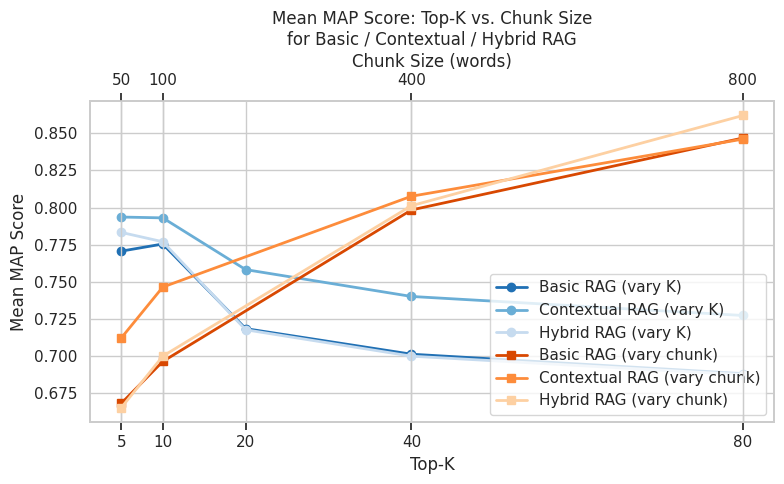

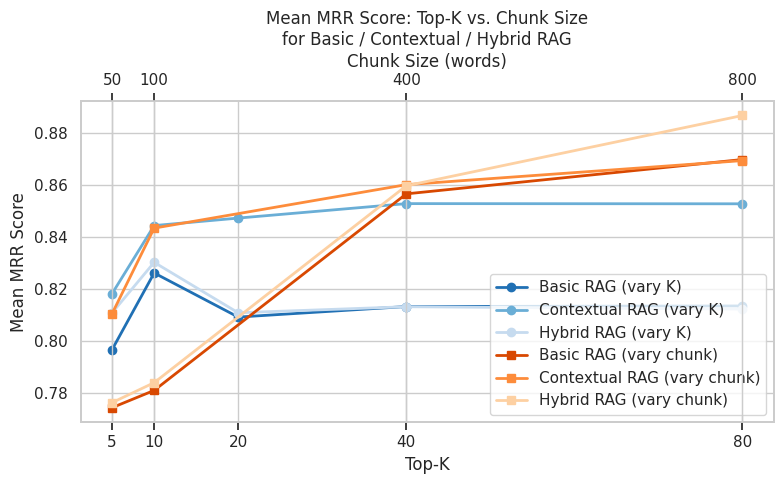

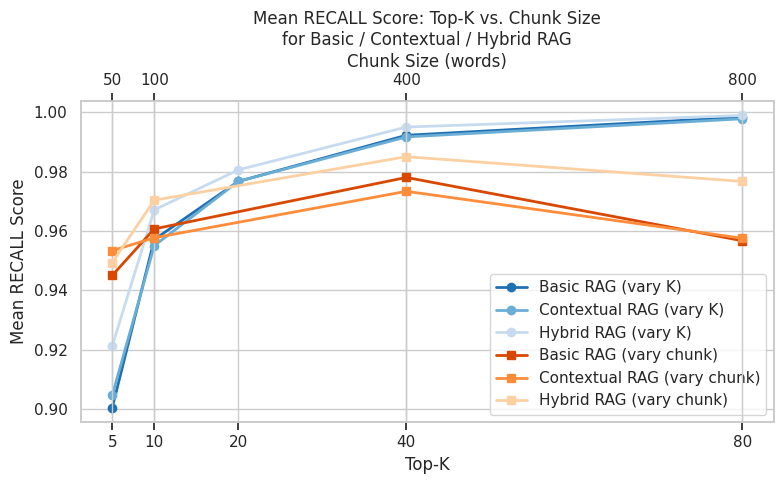

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# ─── CONFIG ────────────────────────────────────────────────────────────────────
METRICS   = ["map", "mrr", "recall"]
rag_types = ["Basic RAG", "Contextual RAG", "Hybrid RAG"]
# ─── PREP ──────────────────────────────────────────────────────────────────────

df = (
    results
    .query("rag_type in @rag_types")
    .loc[lambda d: d.splitting.str.startswith("word_")]
    .copy()
)
df["chunk_size"] = df["splitting"].str.extract(r"word_(\d+)_")[0].astype(int)
df["xpos"]       = df["chunk_size"] / 10

topk_palette  = sns.color_palette("Blues",   n_colors=3)[::-1]
chunk_palette = sns.color_palette("Oranges", n_colors=3)[::-1]
topk_colors   = dict(zip(rag_types, topk_palette))
chunk_colors  = dict(zip(rag_types, chunk_palette))

# ─── PLOTTING ───────────────────────────────────────────────────────────────────
for metr in METRICS:
    fig, ax1 = plt.subplots(figsize=(8, 5))

    # Bottom axis: vary Top-K (solid ●)
    for rt in rag_types:
        sub = df[(df.metric == metr) & (df.rag_type == rt)]
        agg = sub.groupby("topk")["score"].mean().reset_index()
        ax1.plot(
            agg["topk"], agg["score"],
            marker="o",
            color=topk_colors[rt],
            linewidth=2,
            label=f"{rt} (vary K)"
        )
    ax1.set_xlabel("Top-K")
    ax1.set_ylabel(f"Mean {metr.upper()} Score")
    ax1.set_xticks(sorted(df["topk"].unique()))

    # Top axis: vary chunk size (solid ■)
    ax2 = ax1.twiny()
    for rt in rag_types:
        sub = df[(df.metric == metr) & (df.rag_type == rt)]
        agg = sub.groupby("xpos")["score"].mean().reset_index()
        ax2.plot(
            agg["xpos"], agg["score"],
            marker="s",
            color=chunk_colors[rt],
            linewidth=2,
            label=f"{rt} (vary chunk)"
        )
    ax2.set_xlabel("Chunk Size (words)")
    xpos = sorted(df["xpos"].unique())
    ax2.set_xticks(xpos)
    ax2.set_xticklabels((pd.Series(xpos) * 10).astype(int).tolist())

    # Combined legend
    h1, l1 = ax1.get_legend_handles_labels()
    h2, l2 = ax2.get_legend_handles_labels()
    ax1.legend(h1 + h2, l1 + l2, loc="lower right")

    plt.title(f"Mean {metr.upper()} Score: Top-K vs. Chunk Size\nfor Basic / Contextual / Hybrid RAG")
    plt.tight_layout()
    plt.show()

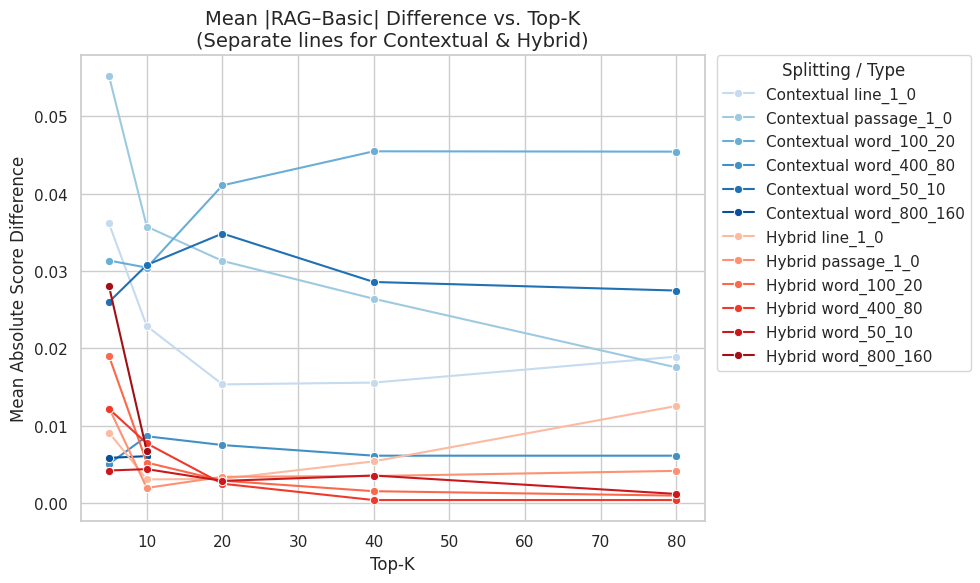

In [5]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# ─── CONFIG ────────────────────────────────────────────────
METRICS    = ["map","mrr","recall"]
splittings = sorted(results["splitting"].unique())
sns.set(style="whitegrid")

# ─── 0) Pivot long → wide, so we have basic/contextual/hybrid columns ─────────
wide = (
    results
      .pivot_table(
         index=["splitting","topk"],
         columns=["rag_type","metric"],
         values="score"
      )
)
wide.columns = [f"{rt}_{m}" for rt, m in wide.columns]  # flatten
wide = wide.reset_index()

# ─── 1) Compute diff_contextual_<m> & diff_hybrid_<m> ───────────────────────
for m in METRICS:
    wide[f"diff_contextual_{m}"] = (
        wide[f"Contextual RAG_{m}"] - wide[f"Basic RAG_{m}"]
    )
    wide[f"diff_hybrid_{m}"] = (
        wide[f"Hybrid RAG_{m}"]     - wide[f"Basic RAG_{m}"]
    )

# ─── 2) Melt out all the diffs and extract type ──────────────────────────────
diff_cols = [c for c in wide.columns if c.startswith("diff_")]
df_diff = (
    wide
      .melt(
         id_vars=["splitting","topk"],
         value_vars=diff_cols,
         var_name="diff_metric",
         value_name="diff_score"
      )
      .dropna(subset=["diff_score"])
)
# pull out “contextual” vs “hybrid”
df_diff["diff_type"] = df_diff["diff_metric"].str.extract(r"diff_(contextual|hybrid)_")
df_diff["abs_diff"]  = df_diff["diff_score"].abs()

# ─── 3) Aggregate across metrics ─────────────────────────────────────────────
agg = (
    df_diff
      .groupby(["topk","diff_type","splitting"])["abs_diff"]
      .mean()
      .reset_index()
)

# build a grouping key for the legend
agg["group"] = agg["diff_type"].str.title() + " " + agg["splitting"]

# ─── 4) Build a palette: 6 blues for contextual, 6 reds for hybrid ──────────
blues = sns.color_palette("Blues",  len(splittings)+1)[1:]  # skip the palest
reds  = sns.color_palette("Reds",   len(splittings)+1)[1:]

palette = {}
for i, s in enumerate(splittings):
    palette[f"Contextual {s}"] = blues[i]
    palette[f"Hybrid {s}"]     = reds[i]

# ─── 5) Plot all 12 lines ───────────────────────────────────────────────────
fig, ax = plt.subplots(figsize=(10,6))
sns.lineplot(
    data=agg,
    x="topk",
    y="abs_diff",
    hue="group",
    palette=palette,
    marker="o",
    ax=ax
)

ax.set_title("Mean |RAG–Basic| Difference vs. Top-K\n(Separate lines for Contextual & Hybrid)", fontsize=14)
ax.set_xlabel("Top-K")
ax.set_ylabel("Mean Absolute Score Difference")
ax.legend(title="Splitting / Type", bbox_to_anchor=(1.02,1), loc="upper left", borderaxespad=0)
plt.tight_layout()
plt.show()

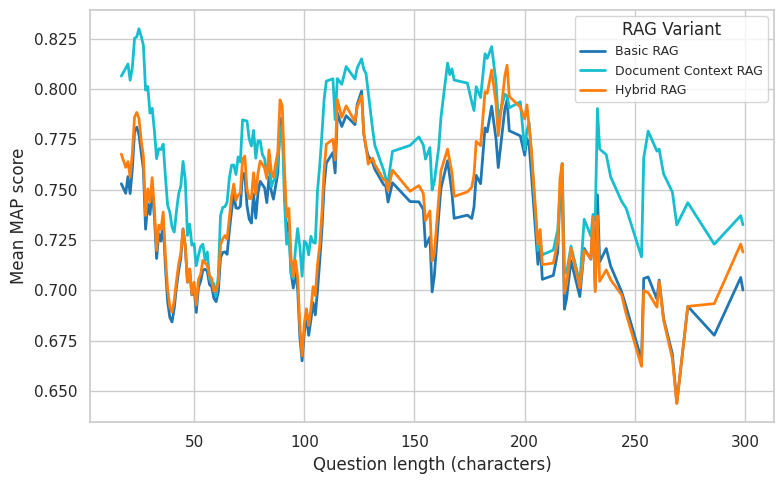

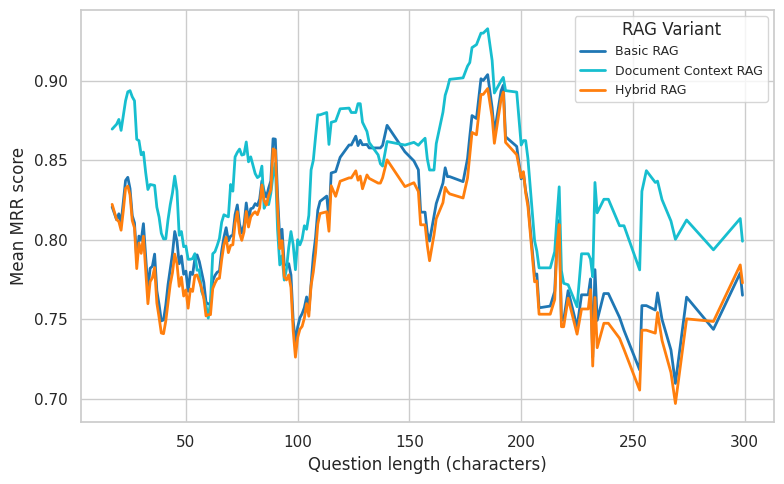

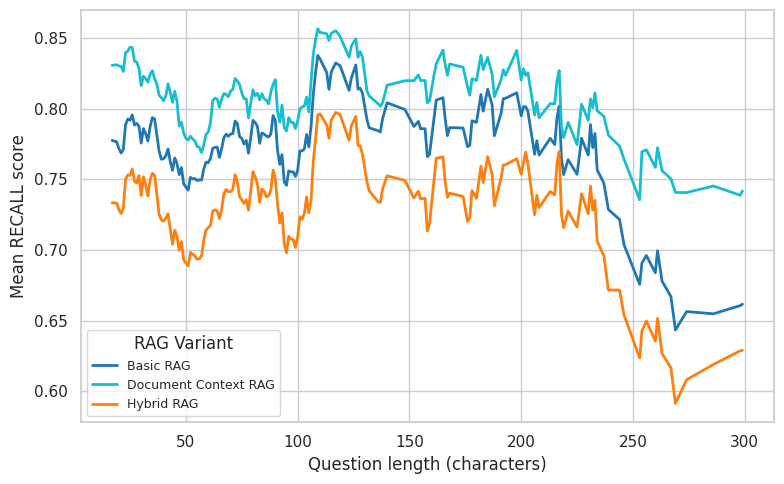

In [3]:
import os
import glob
import re
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# ─── CONFIG ───────────────────────────────────────────────────────────
BASE_DIR = "results/retrieval/2025-07-30_09-27-44/QwenQwen3-Embedding-8B"
PATTERN  = os.path.join(BASE_DIR, "docs_*", "topk_*.pkl")
METRICS  = ["map","mrr","recall"]
sns.set(style="whitegrid")
# ─── BUILD `long` AS BEFORE ────────────────────────────────────────────
records = []
for fp in glob.glob(PATTERN):
    splitting = os.path.basename(os.path.dirname(fp)).removeprefix("docs_")
    df = pd.read_pickle(fp)

    prefixes = {
        col.rsplit("_",1)[0]
        for col in df.columns
        if any(col.endswith(f"_{m}") for m in METRICS)
    }
    prefixes = sorted(p for p in prefixes
                      if all(f"{p}_{m}" in df.columns for m in METRICS))

    for p in prefixes:
        for m in METRICS:
            col = f"{p}_{m}"
            if col not in df: 
                continue
            series = (
                df[col]
                  .dropna()
                  .apply(lambda x: x[0] if isinstance(x,(list,tuple)) and len(x)==1 else x)
                  .astype(float)
            )
            for q, score in zip(df["question"], series):
                records.append({
                    "rag_type": p,            # e.g. "Basic RAG","Contextual RAG","Hybrid RAG","Random"
                    "metric"  : m,
                    "char_len": len(q),
                    "score"   : score
                })

long = pd.DataFrame(records)

# ─── AGGREGATE & FILTER OUT RANDOM ────────────────────────────────────────
agg2 = (
    long
    .groupby(["char_len","rag_type","metric"])["score"]
    .mean()
    .reset_index()
)
agg2 = agg2[agg2.rag_type != "Random"]  # drop the Random variant

# ─── PALETTE (no Random) & SMOOTHING WINDOW ─────────────────────────────
palette = {
    "Basic RAG"     : "tab:blue",
    "Document Context RAG": "tab:cyan",
    "Hybrid RAG"    : "tab:orange",
}
SMOOTH_WINDOW = 15

# ─── PLOT ONE SMOOTHED LINE PER RAG VARIANT ──────────────────────────────
for metric in METRICS:
    dfm = agg2[agg2.metric == metric]
    fig, ax = plt.subplots(figsize=(8,5))

    for rag_type, sub in dfm.groupby("rag_type"):
        sub = sub.sort_values("char_len")
        sub["smooth_score"] = (
            sub["score"]
            .rolling(window=SMOOTH_WINDOW, min_periods=1, center=True)
            .mean()
        )
        ax.plot(
            sub["char_len"],
            sub["smooth_score"],
            label=rag_type,
            color=palette[rag_type],
            linewidth=2
        )

    # ax.set_title(f"{metric.upper()} vs. Question Length\n(rolling‐mean window={SMOOTH_WINDOW})", fontsize=14)
    ax.set_xlabel("Question length (characters)")
    ax.set_ylabel(f"Mean {metric.upper()} score")
    ax.legend(title="RAG Variant", loc="best", fontsize=9)
    plt.tight_layout()
    plt.show()

/tmp/ipykernel_770579/203663787.py:119: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(


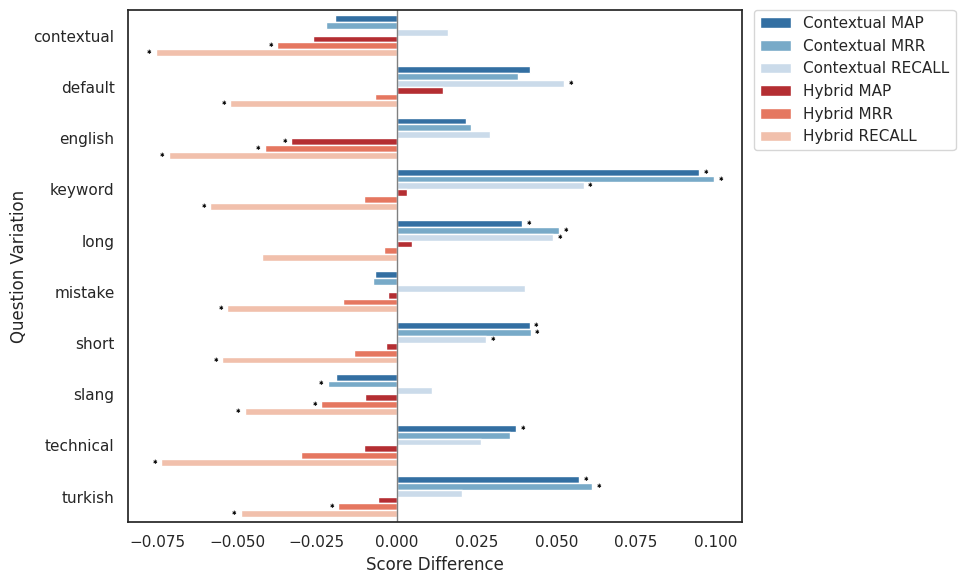

In [58]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from scipy.stats import ttest_1samp
import os
import glob
import re

# ─── CONFIG ────────────────────────────────────────────────────────────────────
BASE_DIR = "results/retrieval/2025-07-30_09-27-44/QwenQwen3-Embedding-8B"
PATTERN  = os.path.join(BASE_DIR, "docs_*", "topk_*.pkl")
METRICS  = ["map", "mrr", "recall"]
# ─── END CONFIG ────────────────────────────────────────────────────────────────

def mean_col(s: pd.Series) -> float:
    """Flatten singleton lists/tuples then take float-mean."""
    clean = (
        s.dropna()
         .apply(lambda x: x[0] if isinstance(x, (list,tuple)) and len(x)==1 else x)
         .astype(float)
    )
    return clean.mean()

# 1) Gather everything into one DataFrame of per-variant scores
records = []
for fp in glob.glob(PATTERN):
    m = re.search(r"topk_(\d+)\.pkl$", fp)
    if not m:
        continue
    topk = int(m.group(1))
    df   = pd.read_pickle(fp)

    if "variant" not in df.columns:
        continue

    for variant, grp in df.groupby("variant"):
        rec = {
            "variant": variant,
            "topk"   : topk,
        }
        # for each metric, grab Basic/Contextual/Hybrid
        for metric in METRICS:
            for kind in ["Basic RAG", "Document Context RAG", "Hybrid RAG"]:
                col = f"{kind}_{metric}"
                rec[f"{kind.replace(' ', '_').lower()}_{metric}"] = (
                    mean_col(grp[col]) if col in grp.columns else np.nan
                )
        records.append(rec)

results = pd.DataFrame(records)

# 2) Compute differences vs Basic
for metric in METRICS:
    results[f"diff_contextual_{metric}"] = (
        results[f"document_context_rag_{metric}"] - results[f"basic_rag_{metric}"]
    )
    results[f"diff_hybrid_{metric}"] = (
        results[f"hybrid_rag_{metric}"] - results[f"basic_rag_{metric}"]
    )

# Keep ordering
variants = sorted(results["variant"].unique())
topks    = sorted(results["topk"].unique())

# 3) Melt into long form for easy plotting
diff_cols = [f"diff_contextual_{m}" for m in METRICS] + \
            [f"diff_hybrid_{m}"   for m in METRICS]

melted = (
    results
    .melt(
        id_vars=["variant", "topk"],
        value_vars=diff_cols,
        var_name="diff_type_metric",
        value_name="diff_score"
    )
    .dropna(subset=["diff_score"])
)
# split into two columns: diff_type (contextual/hybrid) and metric
melted[["diff_type","metric"]] = (
    melted["diff_type_metric"]
      .str
      .extract(r"diff_(contextual|hybrid)_(.*)")
)



# 1) Prepare data
sub = (
    melted
    .query("topk == 5 and diff_type in ['contextual','hybrid']")
    .copy()
)
sub['diff_type'] = sub['diff_type'].str.title()
sub['metric']    = sub['metric'].str.upper()
sub['key']       = sub['diff_type'] + ' ' + sub['metric']

# 2) Compute significance
sig = {}
for (variant, dt, metr), grp in sub.groupby(['variant','diff_type','metric']):
    _, p = ttest_1samp(grp['diff_score'], 0)
    sig[(variant, dt, metr)] = (p < 0.05)

# 3) Build palette & hue_order
metrics   = ["MAP","MRR","RECALL"]
blues  = sns.color_palette("Blues",  3)[::-1]
reds   = sns.color_palette("Reds",   3)[::-1]

palette = {f"Contextual {m}": blues[i] for i,m in enumerate(metrics)}
palette.update({f"Hybrid {m}": reds[i]     for i,m in enumerate(metrics)})

hue_order = [f"Contextual {m}" for m in metrics] + [f"Hybrid {m}" for m in metrics]
variants  = sorted(sub['variant'].unique())

# 4) Plot
fig, ax = plt.subplots(figsize=(10, 6))

sns.barplot(
    data=sub,
    y="variant",
    x="diff_score",
    hue="key",
    hue_order=hue_order,
    palette=palette,
    ci=None,
    order=variants,
    ax=ax
)

# zero‐line
ax.axvline(0, color="gray", linewidth=1)

# annotate significance per container (hue)
for hue_idx, container in enumerate(ax.containers):
    key = hue_order[hue_idx]             # e.g. "Contextual MAP"
    dt, metr = key.split()               # "Contextual","MAP"
    metr = metr.upper()

    for bar_idx, bar in enumerate(container.patches):
        variant = variants[bar_idx]      # same order as y-axis
        if not sig.get((variant, dt, metr), False):
            continue

        x = bar.get_width()
        y = bar.get_y() + bar.get_height()/2

        # small offset in points
        dx = 3 if x >= 0 else -3

        ax.annotate(
            "✱",
            xy=(x, y),
            xytext=(dx, 0),
            textcoords="offset points",
            ha="left" if x >= 0 else "right",
            va="center",
            fontsize=4,
            color="black"
        )

# move legend outside
ax.legend(
    title="",
    bbox_to_anchor=(1.02, 1),
    loc="upper left",
    borderaxespad=0
)

# ax.set_title(
#     "Top-K=5: Contextual & Hybrid vs. Basic RAG Differences\n"
#     "(* p<0.05 by one-sample t-test)"
# )
ax.set_xlabel("Score Difference")
ax.set_ylabel("Question Variation")

plt.tight_layout()
plt.subplots_adjust(right=0.75)  # make room for the legend
plt.show()

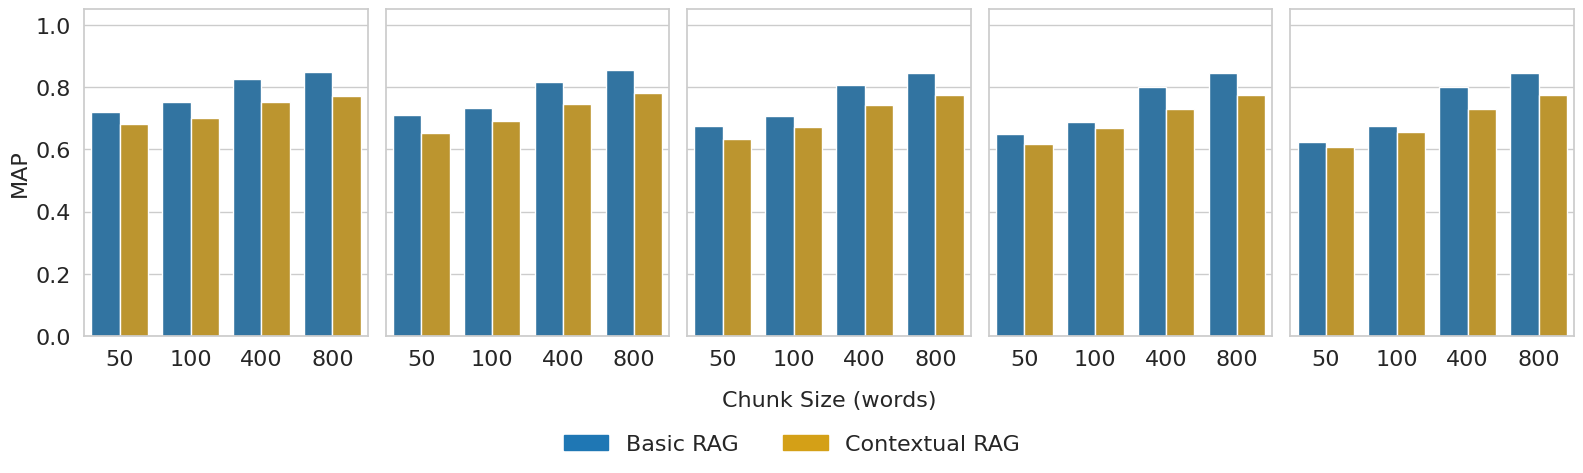

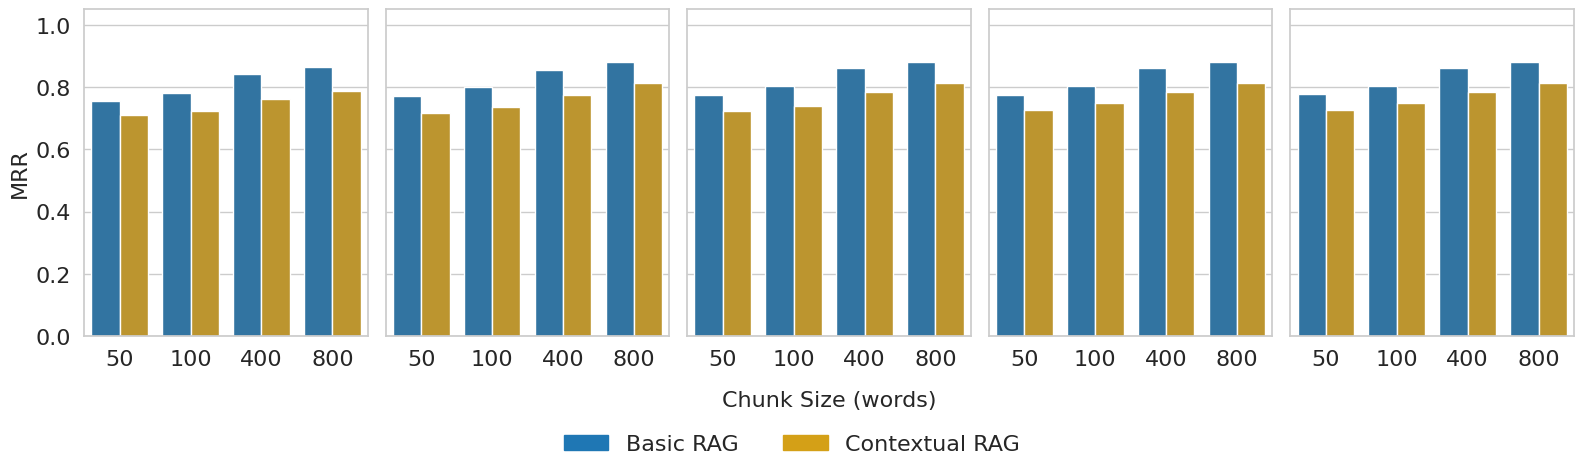

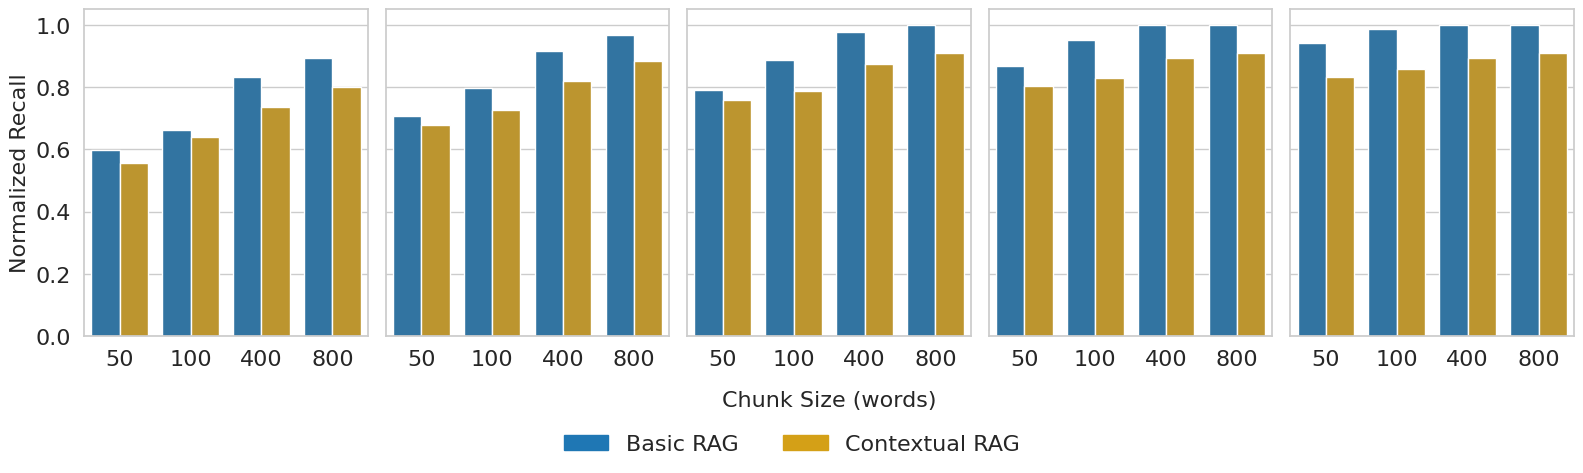

Aggregated scores (metric, topk, rag_type, nominal_size, display_score):
     metric  topk    rag_type nominal_size  display_score
0       map     5       basic           50       0.720350
1       map     5       basic          100       0.753007
2       map     5       basic          400       0.826498
3       map     5       basic          800       0.848743
4       map     5  contextual           50       0.682188
..      ...   ...         ...          ...            ...
115  recall    80       basic          800       1.000000
116  recall    80  contextual           50       0.831220
117  recall    80  contextual          100       0.857231
118  recall    80  contextual          400       0.892857
119  recall    80  contextual          800       0.909091

[120 rows x 5 columns]


In [24]:
import os, glob, re
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# ─── CONFIG (unchanged styling except normalization scope) ─────────────────────
RESULTS_DIR        = "results/retrieval/2025-07-30_09-27-44/QwenQwen3-Embedding-8B"
NOMINAL_SIZES      = [50, 100, 400, 800]
BAR_COLORS         = {"basic": "#1f77b4", "contextual": "#d4a017"}
# Previously only recall was normalized; now extend to all three metrics
METRICS            = ["map", "mrr", "recall"]  # order requested
NORMALIZE_METRICS  = set(METRICS)  # normalize contextual variant for all listed metrics
ASSUME_INFLATION   = True         # heuristic inflation if actual avg words unknown
INFLATION_SMALL    = 1.15         # nominal <= 100
INFLATION_MEDIUM   = 1.12         # 100 < nominal <= 400
INFLATION_LARGE    = 1.10         # nominal > 400
FIG_WIDTH_PER_TOPK = 3.2          # width per subplot
FIG_HEIGHT         = 4.6
SHOW_XLABEL_TOPK   = 20           # only this Top-K gets the x-axis label
X_LABEL_PAD        = 15           # padding for that label (keep exactly as user set)
FONT_SIZE          = 16           # global font size
# ────────────────────────────────────────────────────────────────────────────────

plt.rcParams.update({
    'font.size': FONT_SIZE,
    'axes.titlesize': FONT_SIZE,
    'axes.labelsize': FONT_SIZE,
    'xtick.labelsize': FONT_SIZE,
    'ytick.labelsize': FONT_SIZE,
    'legend.fontsize': FONT_SIZE
})

WORD_SPLIT_RE = re.compile(r"word_(\d+)_")

def extract_nominal_size(splitting: str) -> int | None:
    m = WORD_SPLIT_RE.search(splitting)
    return int(m.group(1)) if m else None

# 1) Load ALL metric pickles once ------------------------------------------------
pattern_all = os.path.join(RESULTS_DIR, "docs_*", "topk_*.pkl")
raw_rows = []
for fp in glob.glob(pattern_all):
    splitting = os.path.basename(os.path.dirname(fp)).removeprefix("docs_")
    nominal = extract_nominal_size(splitting)
    if nominal not in NOMINAL_SIZES:
        continue
    m = re.search(r"topk_(\d+)\.pkl$", fp)
    if not m:
        continue
    topk = int(m.group(1))
    try:
        df = pd.read_pickle(fp)
    except Exception as e:
        print(f"⚠ Failed to read {fp}: {e}")
        continue

    # iterate through metric suffixes for each rag type
    for metric in METRICS:
        suffix = f"_{metric}"
        for col in df.columns:
            if not col.endswith(suffix):
                continue
            prefix = col[:-len(suffix)]
            if prefix == "Basic RAG":
                rag = "basic"
            elif prefix in ("Document Context RAG", "Contextual RAG"):
                rag = "contextual"
            else:
                continue
            series = (df[col]
                      .dropna()
                      .apply(lambda x: x[0] if isinstance(x,(list,tuple)) and len(x)==1 else x)
                      .astype(float))
            if series.empty:
                continue
            raw_rows.append({
                "topk": topk,
                "rag_type": rag,
                "splitting": splitting.lower(),
                "nominal_size": nominal,
                "metric": metric,
                "score": float(series.mean()),
            })

all_metrics_df = pd.DataFrame(raw_rows)
if all_metrics_df.empty:
    raise RuntimeError("No metric data found for specified nominal sizes.")

# 2) Build avg_words table (heuristics) ------------------------------------------
avg_rows = []
for splitting, nominal in all_metrics_df[["splitting","nominal_size"]].drop_duplicates().itertuples(index=False):
    # basic: assume actual == nominal
    avg_rows.append({
        "rag_type": "basic", "splitting": splitting, "nominal_size": nominal, "avg_words": float(nominal)
    })
    # contextual heuristic inflation
    if ASSUME_INFLATION:
        if nominal <= 100:
            est = nominal * INFLATION_SMALL
        elif nominal <= 400:
            est = nominal * INFLATION_MEDIUM
        else:
            est = nominal * INFLATION_LARGE
    else:
        est = nominal
    avg_rows.append({
        "rag_type": "contextual", "splitting": splitting, "nominal_size": nominal, "avg_words": float(est)
    })

avg_words_df = pd.DataFrame(avg_rows)

# 3) Merge -----------------------------------------------------------------------
merged = all_metrics_df.merge(avg_words_df, on=["rag_type","splitting","nominal_size"], how="inner")
if merged.empty:
    raise RuntimeError("Merged metric + avg_words is empty.")

# 4) Compute display_score (normalize contextual for ALL metrics now) ------------
merged["display_score"] = merged.apply(
    lambda r: (r.score * (r.nominal_size / r.avg_words)) if (r.rag_type == "contextual" and r.metric in NORMALIZE_METRICS) else r.score,
    axis=1
)

# 5) Aggregate per metric/topk/rag_type/nominal_size -----------------------------
agg = (merged
       .groupby(["metric","topk","rag_type","nominal_size"], as_index=False)["display_score"].mean())
agg["nominal_size"] = pd.Categorical(agg.nominal_size, categories=NOMINAL_SIZES, ordered=True)

# 6) Plot one figure per metric (no per-subplot titles) -------------------------
sns.set(style="whitegrid")
for metric in METRICS:
    subm = agg[agg.metric == metric]
    if subm.empty:
        print(f"(No data for metric {metric})")
        continue
    available_topks = sorted(subm.topk.unique())
    num_topks = len(available_topks)
    fig, axes = plt.subplots(1, num_topks, figsize=(FIG_WIDTH_PER_TOPK * num_topks, FIG_HEIGHT), sharey=True)
    if num_topks == 1:
        axes = [axes]

    for ax, tk in zip(axes, available_topks):
        sub = subm[subm.topk == tk]
        hue_order = [r for r in ["basic", "contextual"] if r in sub.rag_type.unique()]
        palette = [BAR_COLORS[r] for r in hue_order]
        sns.barplot(
            data=sub,
            x="nominal_size",
            y="display_score",
            hue="rag_type",
            hue_order=hue_order,
            palette=palette,
            edgecolor=None,
            ax=ax
        )
        # No per-subplot title
        if tk == SHOW_XLABEL_TOPK:
            ax.set_xlabel("Chunk Size (words)", labelpad=X_LABEL_PAD, fontsize=FONT_SIZE)
        else:
            ax.set_xlabel("")
        ax.set_ylim(0, 1.05)
        if ax is axes[0]:
            ylabel = "Normalized " + metric.capitalize() if metric == "recall" else metric.upper()
            ax.set_ylabel(ylabel, fontsize=FONT_SIZE)
        else:
            ax.set_ylabel("")
        ax.tick_params(axis='both', which='major', labelsize=FONT_SIZE)
        if ax.get_legend():
            ax.legend_.remove()

    # Unified legend
    handles = []
    labels  = []
    for rag_key, label in [("basic","Basic RAG"), ("contextual","Contextual RAG")]:
        if rag_key in subm.rag_type.unique():
            handles.append(plt.Rectangle((0,0),1,1, color=BAR_COLORS[rag_key]))
            labels.append(label)
    fig.legend(handles, labels, loc='lower center', ncol=len(labels), frameon=False, bbox_to_anchor=(0.5, -0.05), fontsize=FONT_SIZE)

    # No figure-level title
    plt.tight_layout(rect=[0,0.05,1,1])
    plt.show()

print("Aggregated scores (metric, topk, rag_type, nominal_size, display_score):")
print(agg.sort_values(["metric","topk","rag_type","nominal_size"]))

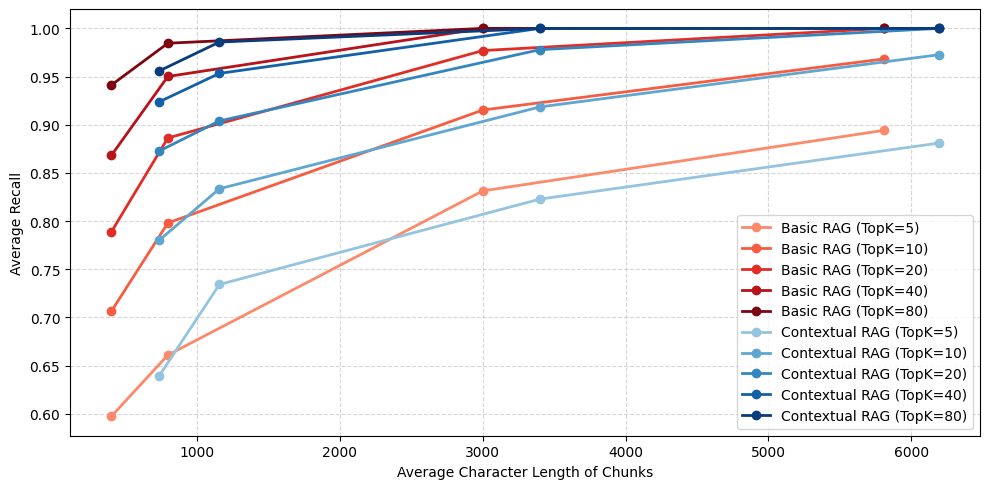

In [2]:
import os
import glob
import re
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from haystack.document_stores.in_memory import InMemoryDocumentStore


# ─── CONFIG ─────────────────────────────────────────────────────────────────────
RESULTS_DIR     = "results/retrieval/2025-07-30_09-27-44/QwenQwen3-Embedding-8B"
PATTERN_RESULTS = os.path.join(RESULTS_DIR, "docs_*", "topk_*.pkl")

DOCSTORE_BASE   = "data/document_stores/Qwen/Qwen3-Embedding-4B/base"
DOCSTORE_CTX    = "data/document_stores/Qwen/Qwen3-Embedding-4B/context"
# ────────────────────────────────────────────────────────────────────────────────


# STEP 1 ── Load avg_char_len from basic and contextual folders
char_records = []

# 1a: BASIC RAG: each store lives under /base/docs_<split>/
for store_dir in glob.glob(os.path.join(DOCSTORE_BASE, "docs_*")):
    split = os.path.basename(store_dir)
    split = re.sub(r"^docs_", "", split)
    split = re.sub(r"_indexing_store\.json$", "", split)
    try:
        store = InMemoryDocumentStore.load_from_disk(store_dir)
        docs = store.filter_documents()
    except Exception as e:
        print(f"⚠ Skipping {store_dir} due to error: {e}")
        continue

    lengths = [len(d.content) for d in docs if hasattr(d, "content")]
    if lengths:
        char_records.append({
            "rag_type": "basic",
            "splitting": split,
            "avg_char_len": sum(lengths) / len(lengths)
        })

# 1b: CONTEXTUAL RAG: under /context/<model>/docs_<split>/
model_dir = os.path.join(DOCSTORE_CTX, "gemma3:12b")
for store_dir in glob.glob(os.path.join(model_dir, "docs_*")):
    split = os.path.basename(store_dir)
    split = re.sub(r"^docs_", "", split)
    split = re.sub(r"_indexing_store\.json$", "", split)
    try:
        store = InMemoryDocumentStore.load_from_disk(store_dir)
        docs = store.filter_documents()
    except Exception as e:
        print(f"⚠ Skipping {store_dir} due to error: {e}")
        continue

    lengths = [len(d.content) for d in docs if hasattr(d, "content")]
    if lengths:
        char_records.append({
            "rag_type": "contextual",
            "splitting": split,
            "avg_char_len": sum(lengths) / len(lengths)
        })

char_df = pd.DataFrame(char_records)
if char_df.empty:
    raise RuntimeError("No document stores could be loaded!")

# STEP 2 ── Load recall values per topk
recall_records = []
prefix_map = {
    "Basic RAG": "basic",
    "Document Context RAG": "contextual"
}
found_prefixes = set()

for fp in glob.glob(PATTERN_RESULTS):
    split = os.path.basename(os.path.dirname(fp)).removeprefix("docs_")
    df = pd.read_pickle(fp)
    topk = int(re.search(r"topk_(\d+)\.pkl$", fp).group(1))

    for col in df.columns:
        if col.endswith("_recall"):
            prefix = col.removesuffix("_recall")
            found_prefixes.add(prefix)
            if prefix not in prefix_map:
                continue
            rag_type = prefix_map[prefix]
            recall_records.append({
                "rag_type": rag_type,
                "splitting": split,
                "topk": topk,
                "recall": df[col].dropna().astype(float).mean()
            })

if not recall_records:
    raise RuntimeError(f"No *_recall columns found. Discovered: {found_prefixes}")

recall_df = pd.DataFrame(recall_records)

# Normalize split names
for df in [char_df, recall_df]:
    df["splitting"] = df["splitting"].str.strip().str.lower()
    df["rag_type"] = df["rag_type"].str.strip().str.lower()

# STEP 3 ── Merge and filter
plot_df = (
    recall_df
    .merge(char_df, on=["rag_type", "splitting"], how="inner")
    .query("splitting.str.startswith('word_')", engine="python")
    .sort_values("avg_char_len")
)

# STEP 4 ── Plot one line per top-k + rag type
plt.figure(figsize=(10, 5))

# Create color maps
reds  = [cm.Reds(i) for i in np.linspace(0.4, 0.95, 5)]
blues = [cm.Blues(i) for i in np.linspace(0.4, 0.95, 5)]

# Sort topks to keep color order consistent
topk_order = sorted(plot_df["topk"].unique())
topk_to_idx = {tk: i for i, tk in enumerate(topk_order)}

for (rag_type, topk), group in plot_df.groupby(["rag_type", "topk"]):
    idx = topk_to_idx[topk]
    if rag_type == "basic":
        color = reds[idx]
    else:
        color = blues[idx]

    label = f"{rag_type.capitalize()} RAG (TopK={topk})"
    plt.plot(
        group["avg_char_len"],
        group["recall"],
        marker="o",
        linewidth=2,
        color=color,
        label=label
    )

plt.xlabel("Average Character Length of Chunks")
plt.ylabel("Average Recall")
# plt.title("Recall vs. Avg. Chunk Length (per RAG Type & Top-K)")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

In [29]:
print("🔍 Splits from document stores:")
print(char_df[["rag_type", "splitting"]].sort_values(["rag_type", "splitting"]))

print("\n📊 Splits from recall pickles:")
print(recall_df[["rag_type", "splitting"]].sort_values(["rag_type", "splitting"]))

🔍 Splits from document stores:
      rag_type     splitting
3        basic      line_1_0
0        basic   passage_1_0
1        basic   word_100_20
4        basic   word_400_80
2        basic    word_50_10
5        basic  word_800_160
9   contextual      line_1_0
15  contextual      line_1_0
6   contextual   passage_1_0
12  contextual   passage_1_0
7   contextual   word_100_20
13  contextual   word_100_20
10  contextual   word_400_80
16  contextual   word_400_80
8   contextual    word_50_10
14  contextual    word_50_10
11  contextual  word_800_160
17  contextual  word_800_160

📊 Splits from recall pickles:
      rag_type     splitting
0        basic      line_1_0
1        basic   passage_1_0
2        basic   word_100_20
3        basic   word_400_80
4        basic    word_50_10
5        basic  word_800_160
6   contextual      line_1_0
7   contextual   passage_1_0
8   contextual   word_100_20
9   contextual   word_400_80
10  contextual    word_50_10
11  contextual  word_800_160


## Rewriter

/tmp/ipykernel_2251784/682472804.py:56: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(x_labels)
/tmp/ipykernel_2251784/682472804.py:56: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(x_labels)
/tmp/ipykernel_2251784/682472804.py:56: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(x_labels)


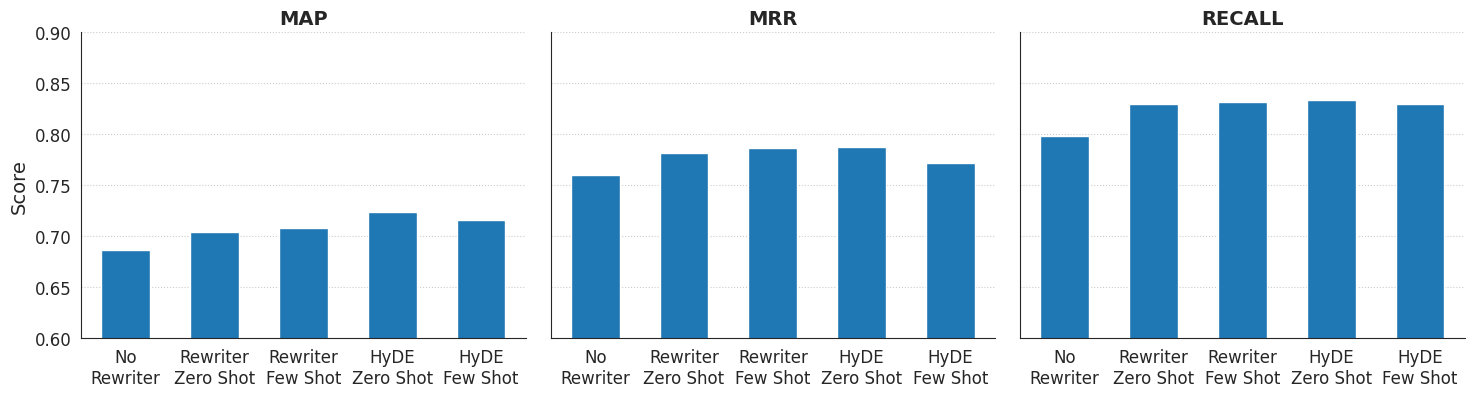

In [36]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_pickle("results/retrieval/rewriter/2025-08-02_14-46-06.pkl")

# Configuration names and metric types
configs = [
    "No Rewriting",
    "Rewriting Zero Shot",
    "Rewriting Few Shot",
    "HyDE Zero Shot",
    "HyDE Few Shot"
]
metrics = ["map", "mrr", "recall"]

# Summary (mean over all rows for each config/metric)
summary = {
    cfg: [df[f"{cfg}_{metric}"].mean() for metric in metrics]
    for cfg in configs
}
summary_df = pd.DataFrame(summary, index=[m.upper() for m in metrics])

# Prepare multiline labels for plotting (do not mutate original configs if reused elsewhere)
plot_configs = [
    c.replace("No Rewriting", "No\nRewriter")
     .replace("Rewriting Zero Shot", "Rewriter\nZero Shot")
     .replace("Rewriting Few Shot", "Rewriter\nFew Shot")
     .replace("HyDE Zero Shot", "HyDE\nZero Shot")
     .replace("HyDE Few Shot", "HyDE\nFew Shot")
    for c in configs
]

# ... existing code that builds data frames ...
# When plotting, use plot_configs instead of configs for x tick labels
try:
    x_labels = plot_configs
except NameError:
    pass

# Long form
long_df = (
    summary_df
      .reset_index(names="metric")
      .melt(id_vars="metric", var_name="configuration", value_name="score")
)
long_df["configuration"] = pd.Categorical(long_df["configuration"], categories=configs, ordered=True)
long_df["metric"] = pd.Categorical(long_df["metric"], categories=[m.upper() for m in metrics], ordered=True)

# Plot: three vertical bar charts (score on y, configuration on x)
fig, axes = plt.subplots(1, 3, figsize=(15, 4.2), sharey=True)

for ax, metr in zip(axes, [m.upper() for m in metrics]):
    sub = long_df[long_df.metric == metr].sort_values("configuration")
    ax.bar(sub["configuration"], sub["score"], color=BASIC_RAG_COLOR, width=0.55)
    ax.set_ylim(0.6, 0.9)
    ax.set_xticklabels(x_labels)
    ax.set_ylabel("Score" if ax is axes[0] else "")
    ax.set_title(metr, fontweight="bold")
    # Value labels above bars
    # for x, (cfg, score) in enumerate(zip(sub["configuration"], sub["score"])):
    #     ax.text(x, score + 0.01, f"{score:.3f}", ha="center", va="bottom", fontsize=9)
    ax.grid(axis="y", linestyle=":", alpha=1)

plt.tight_layout()
plt.show()

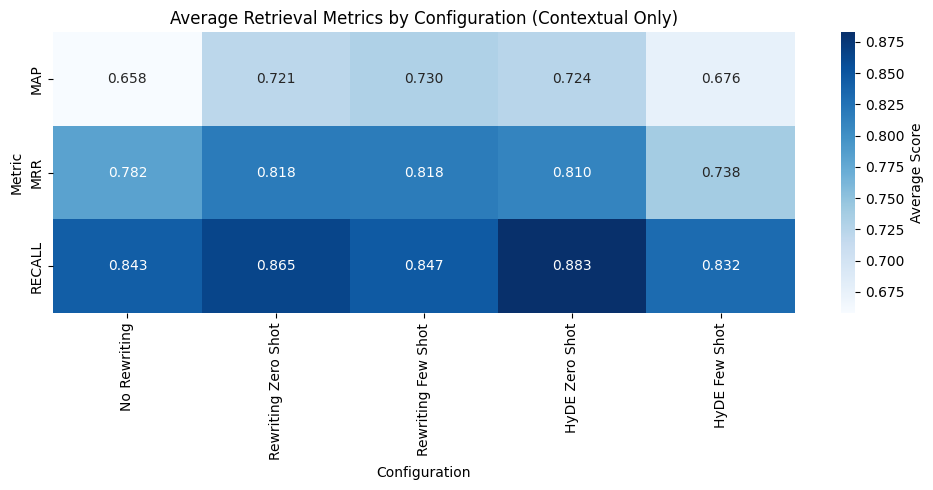

In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Replace this with your actual DataFrame if it's not already loaded
# df = pd.read_csv("your_results.csv")

# Filter rows where variant is "contextual"
df_contextual = df[df["variant"] == "contextual"]

# Configuration names and metric types
configs = [
    "No Rewriting",
    "Rewriting Zero Shot",
    "Rewriting Few Shot",
    "HyDE Zero Shot",
    "HyDE Few Shot"
]
metrics = ["map", "mrr", "recall"]

# Create a summary DataFrame with average scores for contextual rows only
summary = {
    cfg: [
        df_contextual[f"{cfg}_{metric}"].mean() for metric in metrics
    ]
    for cfg in configs
}
summary_df = pd.DataFrame(summary, index=[m.upper() for m in metrics])

# Plot the heatmap
plt.figure(figsize=(10, 5))
sns.heatmap(summary_df, annot=True, cmap="Blues", fmt=".3f", cbar_kws={'label': 'Average Score'})
plt.title("Average Retrieval Metrics by Configuration (Contextual Only)")
plt.xlabel("Configuration")
plt.ylabel("Metric")
plt.tight_layout()
plt.show()

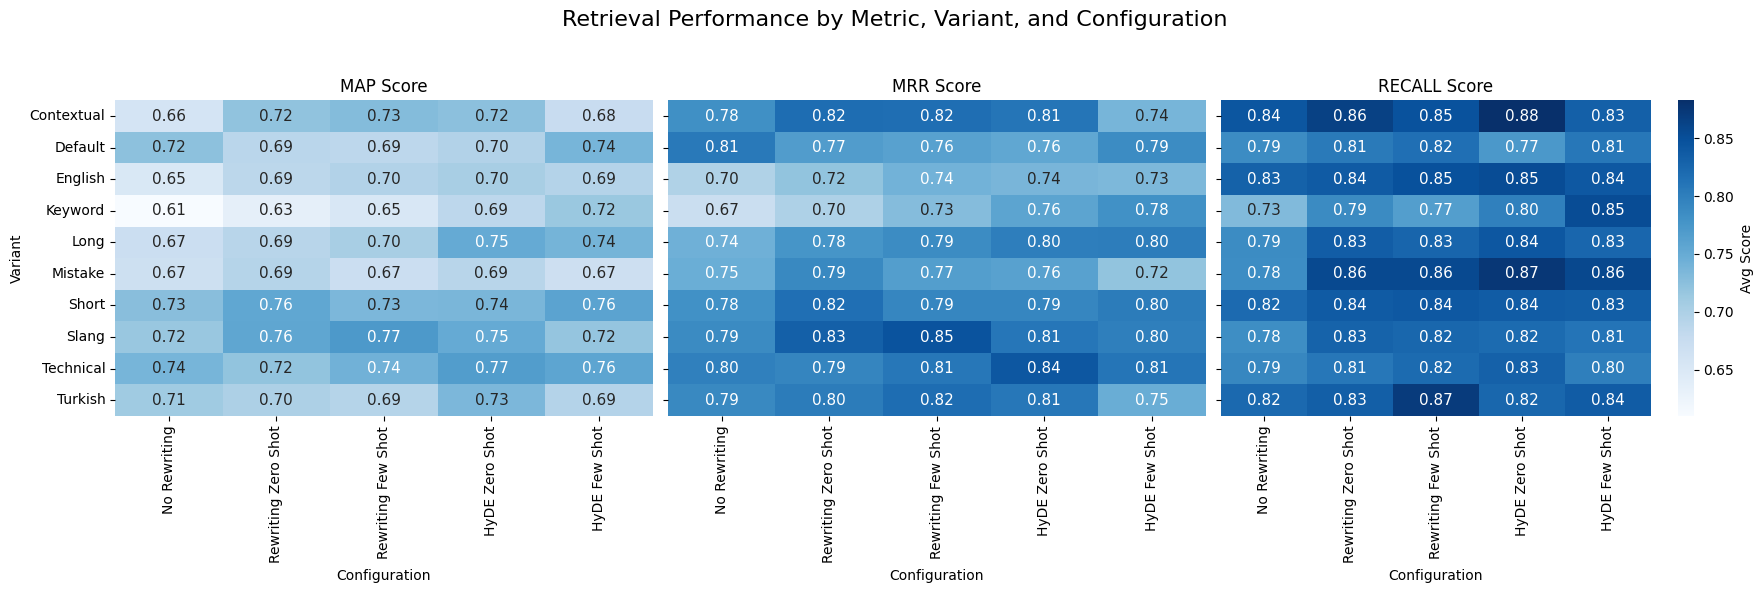

In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Replace with your actual DataFrame if not already loaded
# df = pd.read_csv("your_results.csv")

# Desired fixed configuration order
configs = [
    "No Rewriting",
    "Rewriting Zero Shot",
    "Rewriting Few Shot",
    "HyDE Zero Shot",
    "HyDE Few Shot"
]
metrics = ["map", "mrr", "recall"]

# Collect all scores for shared color scale
all_scores = []
heatmap_data_by_metric = {}

for metric in metrics:
    records = []
    for variant in df["variant"].unique():
        df_variant = df[df["variant"] == variant]
        for config in configs:
            col_name = f"{config}_{metric}"
            if col_name in df_variant.columns:
                score = df_variant[col_name].mean()
                all_scores.append(score)
                records.append({
                    "Variant": variant.capitalize(),
                    "Configuration": config,
                    "Score": score
                })
    metric_df = pd.DataFrame(records)
    # Enforce config order as categorical type
    metric_df["Configuration"] = pd.Categorical(metric_df["Configuration"], categories=configs, ordered=True)
    metric_df = metric_df.sort_values(["Variant", "Configuration"])
    heatmap_data_by_metric[metric] = metric_df.pivot(index="Variant", columns="Configuration", values="Score")

# Determine global color scale limits
vmin = min(all_scores)
vmax = max(all_scores)

# Create side-by-side heatmaps
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

for i, metric in enumerate(metrics):
    sns.heatmap(
        heatmap_data_by_metric[metric],
        ax=axes[i],
        annot=True,
        fmt=".2f",
        cmap="Blues",
        vmin=vmin,
        vmax=vmax,
        annot_kws={"size": 11},
        cbar=i == 2,
        cbar_kws={'label': 'Avg Score'} if i == 2 else None
    )
    axes[i].set_title(f"{metric.upper()} Score")
    axes[i].set_xlabel("Configuration")
    if i == 0:
        axes[i].set_ylabel("Variant")
    else:
        axes[i].set_ylabel("")

plt.suptitle("Retrieval Performance by Metric, Variant, and Configuration", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

/tmp/ipykernel_459873/695464477.py:81: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(


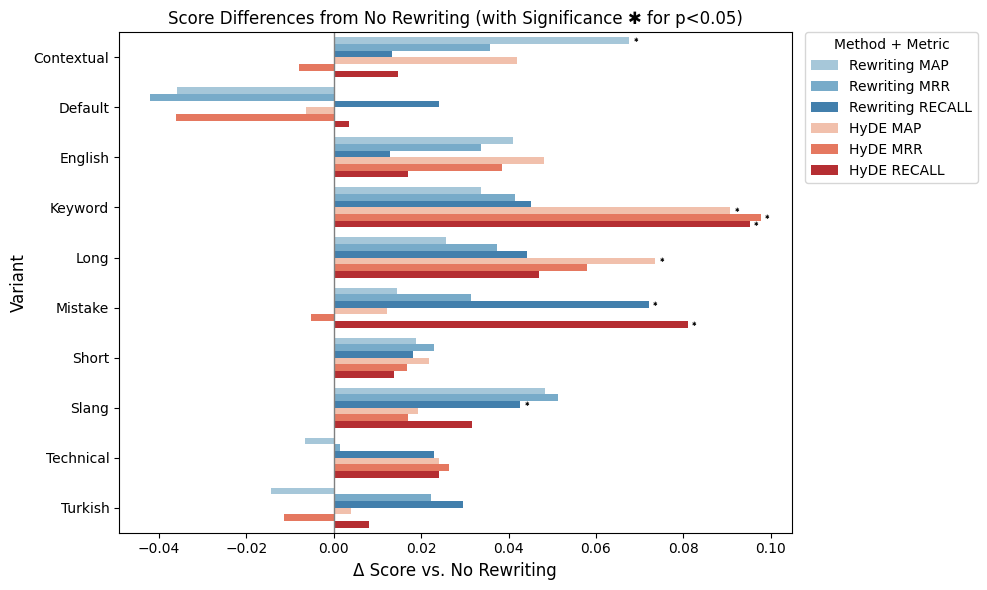

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import ttest_1samp

# Replace this with your actual DataFrame if not already loaded
# df = pd.read_csv("your_results.csv")

configs_grouped = {
    "Rewriting": ["Rewriting Zero Shot", "Rewriting Few Shot"],
    "HyDE": ["HyDE Zero Shot", "HyDE Few Shot"]
}
baseline = "No Rewriting"
metrics = ["map", "mrr", "recall"]

# ─── 1) Gather per-row deltas and compute significance ─────────────────────────
records = []
sig = {}  # will hold significance flags keyed by (Variant, Method, Metric)

for variant in df["variant"].unique():
    df_variant = df[df["variant"] == variant]
    variant_label = variant.capitalize()

    for method, configs in configs_grouped.items():
        for metric in metrics:
            baseline_col = f"{baseline}_{metric}"
            # pick only the cfg‐columns that exist
            cfg_cols = [f"{cfg}_{metric}" for cfg in configs if f"{cfg}_{metric}" in df_variant.columns]
            if baseline_col not in df_variant.columns or not cfg_cols:
                continue

            # per‐row baseline and method‐avg
            baseline_vec = df_variant[baseline_col].astype(float)
            method_avg = df_variant[cfg_cols].astype(float).mean(axis=1)

            # compute per‐row difference
            diffs = (method_avg - baseline_vec).dropna()
            if diffs.empty:
                continue

            # mean delta and t-test vs zero
            delta = diffs.mean()
            _, p_val = ttest_1samp(diffs, 0.0)
            is_signif = (p_val < 0.05)

            # record for plotting
            records.append({
                "Variant": variant_label,
                "Method": method,
                "Metric": metric.upper(),
                "Delta": delta,
                "Label": f"{method} {metric.upper()}"
            })
            sig[(variant_label, method, metric.upper())] = is_signif

plot_df = pd.DataFrame(records)

# ─── 2) Define color palette and plotting order ────────────────────────────────
palette = {
    "Rewriting MAP": "#9ecae1",
    "Rewriting MRR": "#6baed6",
    "Rewriting RECALL": "#3182bd",
    "HyDE MAP":     "#fcbba1",
    "HyDE MRR":     "#fb6a4a",
    "HyDE RECALL":  "#cb181d"
}

# ensure consistent hue order
hue_order = []
for method in configs_grouped:
    for m in ["MAP", "MRR", "RECALL"]:
        key = f"{method} {m}"
        if key in plot_df["Label"].unique():
            hue_order.append(key)

variants = sorted(plot_df["Variant"].unique())

# ─── 3) Create barplot and annotate significance ───────────────────────────────
fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(
    data=plot_df,
    x="Delta",
    y="Variant",
    hue="Label",
    palette=palette,
    hue_order=hue_order,
    order=variants,
    ci=None,
    ax=ax
)

# zero‐line
ax.axvline(0, color="gray", linewidth=1)

# annotate “✱” for p < 0.05
for hue_idx, container in enumerate(ax.containers):
    key = hue_order[hue_idx]          # e.g. "Rewriting MAP"
    method, metr = key.split()        # e.g. ("Rewriting","MAP")
    for bar_idx, bar in enumerate(container.patches):
        variant = variants[bar_idx]
        if not sig.get((variant, method, metr), False):
            continue
        x = bar.get_width()
        y = bar.get_y() + bar.get_height() / 2
        # small horizontal offset so the star doesn’t overlap the bar edge
        dx = 3 if x >= 0 else -3
        ax.annotate(
            "✱",
            xy=(x, y),
            xytext=(dx, 0),
            textcoords="offset points",
            ha="left" if x >= 0 else "right",
            va="center",
            fontsize=4,
            color="black"
        )

# ─── 4) Final styling ─────────────────────────────────────────────────────────
ax.set_title("Score Differences from No Rewriting (with Significance ✱ for p<0.05)")
ax.set_xlabel("Δ Score vs. No Rewriting", fontsize=12)
ax.set_ylabel("Variant", fontsize=12)
ax.legend(
    title="Method + Metric", 
    bbox_to_anchor=(1.02, 1),
    loc="upper left",
    borderaxespad=0
)
plt.tight_layout()
plt.show()

In [26]:
# right after the t-test, instead of just saving the boolean, also save the p-value
pvals = []
for variant in df["variant"].unique():
    df_variant = df[df["variant"] == variant]
    variant_label = variant.capitalize()

    for method, configs in configs_grouped.items():
        for metric in metrics:
            baseline_col = f"{baseline}_{metric}"
            cfg_cols = [f"{cfg}_{metric}" for cfg in configs if f"{cfg}_{metric}" in df_variant.columns]
            if baseline_col not in df_variant.columns or not cfg_cols:
                continue

            baseline_vec = df_variant[baseline_col].astype(float)
            method_avg  = df_variant[cfg_cols].astype(float).mean(axis=1)
            diffs        = (method_avg - baseline_vec).dropna()

            if len(diffs) < 2:
                continue

            delta = diffs.mean()
            tstat, p_val = ttest_1samp(diffs, 0.0)
            is_signif = (p_val < 0.05)

            # record for the barplot
            records.append({
                "Variant": variant_label,
                "Method": method,
                "Metric": metric.upper(),
                "Delta": delta,
                "Label": f"{method} {metric.upper()}"
            })
            sig[(variant_label, method, metric.upper())] = is_signif

            # record for your inspection
            pvals.append({
                "Variant": variant_label,
                "Method": method,
                "Metric": metric.upper(),
                "Mean Δ": delta,
                "p-value": p_val,
                "Significant?": is_signif
            })

# turn it into a DataFrame and print:
pval_df = pd.DataFrame(pvals)
print(pval_df.sort_values("p-value"))

       Variant     Method  Metric    Mean Δ   p-value  Significant?
22     English       HyDE     MRR -0.091200  0.010396          True
52     Mistake       HyDE     MRR  0.076677  0.041620          True
51     Mistake       HyDE     MAP  0.063151  0.047735          True
12       Slang  Rewriting     MAP  0.060669  0.063690         False
48     Mistake  Rewriting     MAP  0.057851  0.075688         False
26     Keyword  Rewriting  RECALL  0.058333  0.089672         False
13       Slang  Rewriting     MRR  0.065437  0.103254         False
30       Short  Rewriting     MAP -0.034208  0.111163         False
1      Default  Rewriting     MRR -0.055384  0.133813         False
21     English       HyDE     MAP -0.035852  0.137495         False
20     English  Rewriting  RECALL -0.016667  0.159037         False
5      Default       HyDE  RECALL  0.033333  0.159037         False
50     Mistake  Rewriting  RECALL  0.041667  0.167428         False
19     English  Rewriting     MRR -0.042103  0.1

## Reranker Analysis

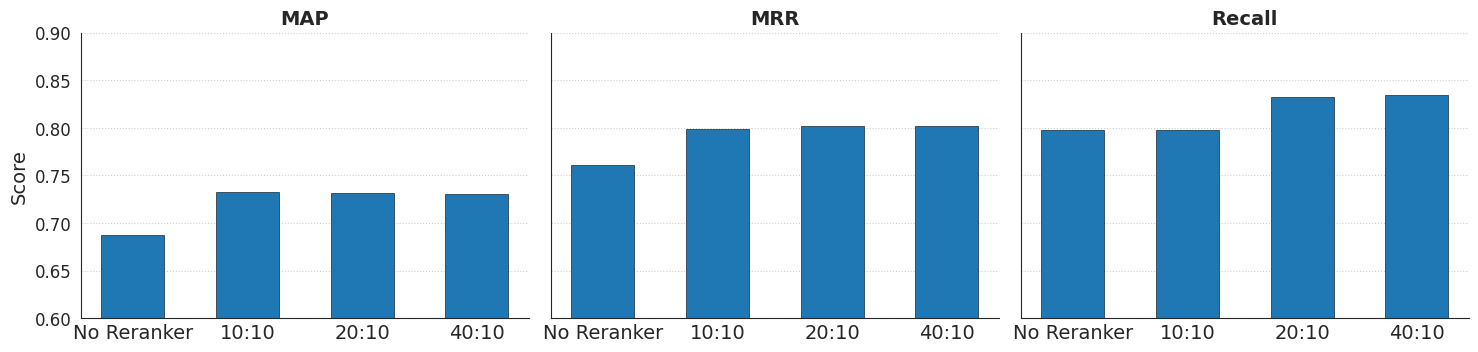

In [29]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re

# 1) Load your DF
df = pd.read_pickle("results/retrieval/reranker/2025-07-30_09-41-32.pkl")

# 2) Find all the *_map, *_mrr, *_recall columns
score_cols = [c for c in df.columns if re.search(r"_(map|mrr|recall)$", c)]

# 3) Compute the mean score for each
mean_scores = df[score_cols].mean()

# 4) Build a clean label for each column
records = []
for col in score_cols:
    m = re.match(r"(?P<model>.+?)_(?P<k>\d+)_(?P<metric>map|mrr|recall)$", col)
    if not m:
        continue
    model, k_str, metric = m.group("model"), m.group("k"), m.group("metric")
    # Updated label style: "n:10" etc, keep baseline label
    label = "No Reranker" if model == "None" else f"{k_str}:10"
    records.append({
        "label":  label,
        "metric": metric,
        "score":  mean_scores[col]
    })

plot_df = pd.DataFrame(records)

# 5) Collapse duplicates just in case
agg = plot_df.groupby(["label","metric"], as_index=False)["score"].mean()

# 6) Pivot to wide form
pivot = agg.pivot(index="label", columns="metric", values="score")

# 7) Only keep & order the labels you care about
desired = [
    "No Reranker",
    "10:10",
    "20:10",
    "40:10",
    "80:10",
]
present = [lbl for lbl in desired if lbl in pivot.index]
pivot = pivot.loc[present]

# 8) Bar charts (one metric per subplot). All bars BASIC_RAG_COLOR.
metrics_order = [m for m in ['map','mrr','recall'] if m in pivot.columns]

x_labels = list(pivot.index)
x = np.arange(len(x_labels))

# More compact figure width to reduce whitespace
fig_width = max(3.2 * len(metrics_order), 0.75 * len(x_labels))
fig, axes = plt.subplots(1, len(metrics_order), figsize=(15, 4.2), sharey=True)
if len(metrics_order) == 1:
    axes = [axes]

# Fixed y limits as requested
ymin, ymax = 0.6, 0.9

for idx, metric in enumerate(metrics_order):
    ax = axes[idx]
    scores = pivot[metric].values

    ax.bar(x, scores, color=BASIC_RAG_COLOR, width=0.55, edgecolor='black', linewidth=0.4)

    ax.set_title(metric.capitalize() if metric == "recall" else metric.upper(), pad=6, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(x_labels, fontsize=14)
    ax.set_ylim(ymin, ymax)

    # Remove x-axis tick lines (tick marks)
    ax.tick_params(axis='x', length=0)

    # Add horizontal grid lines at y ticks only
    yticks = np.arange(ymin, ymax + 0.001, 0.05)
    ax.set_yticks(yticks)
    if idx == 0:
        ax.set_ylabel("Score")
    else:
        ax.tick_params(axis='y', which='both', length=0)
    ax.grid(axis='y', linestyle=':', alpha=1)

    # Ensure no vertical grid lines
    ax.grid(False, axis='x')

# Tight spacing between subplots
fig.subplots_adjust(wspace=0.05, left=0.07, right=0.995, bottom=0.22, top=0.90)
plt.show()

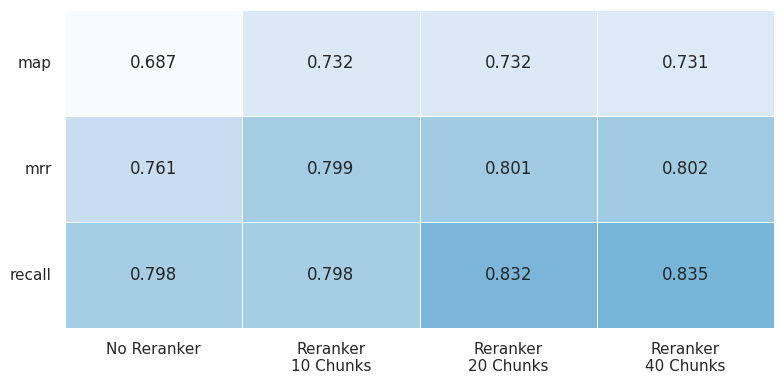

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

# assume `pivot` as before, with index = configurations, columns = [map, mrr, recall]

sns.set(style="white")
sns.set_context("notebook")

fig, ax = plt.subplots(figsize=(8, 4))

# transpose pivot to swap axes
sns.heatmap(
    pivot.T,
    annot=True,
    fmt=".3f",
    cmap="Blues",  # ← changed from "Blues" to "Greens"
    cbar=False,
    vmax=1.0,
    # cbar_kws={"label": "Average Score"},
    linewidths=0.5,   # ← set to 0 to remove spacing between cells
    ax=ax
)

# titles and labels
# ax.set_title("Average Retrieval Metrics by Configuration (Contextual Only)", pad=16)
ax.set_xlabel("")
ax.set_ylabel("")

# rotate tick labels
plt.xticks(rotation=0)
plt.yticks(rotation=0)

plt.tight_layout()
plt.show()
fig.savefig('figures/retrieval_reranker.pgf')

## Closed vs. Open Source

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ─── Load or define your DataFrame ─────────────────────────────────────────────
df = pd.read_pickle("results/retrieval/open_closed/2025-08-04_14-19-44/open_closed_result.pkl")
# ────────────────────────────────────────────────────────────────────────────────

# 1) Define your setups & metrics
setups = [
    "Open Source",
    "Open Source with Rewriting",
    "Closed Source",
    "Closed Source with Rewriting"
]
metrics = ["map", "mrr", "recall"]

# 2) Compute mean for each (setup, metric), optionally ignoring 0 & NaN
data = {}
for setup in setups:
    means = []
    for m in metrics:
        col = f"{setup}_{m}"
        # coerce to numeric and turn zeros into NaN so they're skipped in the mean:
        vals = pd.to_numeric(df[col], errors="coerce").replace(0, np.nan)
        means.append(vals.mean())
    data[setup] = means

# 3) Build a “metrics_df” where rows are metrics, columns are setups
metrics_df = pd.DataFrame(
    data,
    index=[m.upper() for m in metrics]
)

# 4) Transpose so each setup becomes a row with three bars
plot_df = metrics_df.T  # now index=setup, columns=['MAP','MRR','RECALL']

# 5) Plot
ax = plot_df.plot(
    kind='bar',
    figsize=(12, 6),
    edgecolor='black'
)
ax.set_title("Retrieval Scores by Configuration")
ax.set_xlabel("Setup")
ax.set_ylabel("Average Score")
ax.set_xticklabels(plot_df.index, rotation=30, ha='right')
ax.legend(title="Metric")
plt.tight_layout()
plt.show()

KeyError: 'Open Source_map'

In [73]:
df.head(20)

,question,references,groundTruth,source_file,variations_pretty,documents,variant,prev_messages,Open Source_map,Open Source_mrr,Open Source_recall,Open Source with Rewriting_map,Open Source with Rewriting_mrr,Open Source with Rewriting_recall,Closed Source_map,Closed Source_mrr,Closed Source_recall,Closed Source with Rewriting_map,Closed Source with Rewriting_mrr,Closed Source with Rewriting_recall
0,Wie läuft eine äußere Wendung genau ab und was...,[Eine äußere Wendung findet in der Regel in ei...,Eine äußere Wendung findet ambulant in einer K...,Äußere Wendung.md,"""{\""contextual\"": [{\""role\"": \""user\"", \""mess...",[Document(id=a3459c13c24fb9193e348f5e6777c69d7...,default,[],1.000000,1.000000,1.0,0.333333,0.333333,1.0,0.500000,0.500000,1.0,0.625000,1.000000,1.0
1,Und was passiert dann genau davor?,[Eine äußere Wendung findet in der Regel in ei...,Eine äußere Wendung findet ambulant in einer K...,Äußere Wendung.md,"""{\""contextual\"": [{\""role\"": \""user\"", \""mess...",[Document(id=a3459c13c24fb9193e348f5e6777c69d7...,contextual,"[Ich habe von der äußeren Wendung gehört, könn...",0.700000,1.000000,1.0,0.833333,1.000000,1.0,0.809524,1.000000,1.0,0.833333,1.000000,1.0
2,Wie genau läuft so ne äußere Wendung ab und wa...,[Eine äußere Wendung findet in der Regel in ei...,Eine äußere Wendung findet ambulant in einer K...,Äußere Wendung.md,"""{\""contextual\"": [{\""role\"": \""user\"", \""mess...",[Document(id=a3459c13c24fb9193e348f5e6777c69d7...,slang,[],1.000000,1.000000,1.0,1.000000,1.000000,1.0,0.333333,0.333333,1.0,0.333333,0.333333,1.0
3,How is an external version performed exactly a...,[Eine äußere Wendung findet in der Regel in ei...,Eine äußere Wendung findet ambulant in einer K...,Äußere Wendung.md,"""{\""contextual\"": [{\""role\"": \""user\"", \""mess...",[Document(id=a3459c13c24fb9193e348f5e6777c69d7...,english,[],0.333333,0.333333,1.0,0.250000,0.250000,1.0,1.000000,1.000000,1.0,0.500000,0.500000,1.0
4,äußere Wendung Ablauf Vorbereitung,[Eine äußere Wendung findet in der Regel in ei...,Eine äußere Wendung findet ambulant in einer K...,Äußere Wendung.md,"""{\""contextual\"": [{\""role\"": \""user\"", \""mess...",[Document(id=a3459c13c24fb9193e348f5e6777c69d7...,keyword,[],0.225000,0.250000,1.0,0.183333,0.166667,1.0,0.291667,0.333333,1.0,0.225000,0.250000,1.0
5,Wie läuft eine äußere Wendung ab?,[Eine äußere Wendung findet in der Regel in ei...,Eine äußere Wendung findet ambulant in einer K...,Äußere Wendung.md,"""{\""contextual\"": [{\""role\"": \""user\"", \""mess...",[Document(id=a3459c13c24fb9193e348f5e6777c69d7...,short,[],0.787500,1.000000,1.0,0.830357,1.000000,1.0,0.839286,1.000000,1.0,0.871111,1.000000,1.0
6,"Können Sie mir bitte ausführlich erklären, wie...",[Eine äußere Wendung findet in der Regel in ei...,Eine äußere Wendung findet ambulant in einer K...,Äußere Wendung.md,"""{\""contextual\"": [{\""role\"": \""user\"", \""mess...",[Document(id=a3459c13c24fb9193e348f5e6777c69d7...,long,[],1.000000,1.000000,1.0,1.000000,1.000000,1.0,1.000000,1.000000,1.0,1.000000,1.000000,1.0
7,"Könnten Sie detailliert erläutern, wie eine ex...",[Eine äußere Wendung findet in der Regel in ei...,Eine äußere Wendung findet ambulant in einer K...,Äußere Wendung.md,"""{\""contextual\"": [{\""role\"": \""user\"", \""mess...",[Document(id=a3459c13c24fb9193e348f5e6777c69d7...,technical,[],0.000000,0.000000,0.0,1.000000,1.000000,1.0,0.000000,0.000000,0.0,1.000000,1.000000,1.0
8,Wie läuft eine äussere Wendung genau ab und wa...,[Eine äußere Wendung findet in der Regel in ei...,Eine äußere Wendung findet ambulant in einer K...,Äußere Wendung.md,"""{\""contextual\"": [{\""role\"": \""user\"", \""mess...",[Document(id=a3459c13c24fb9193e348f5e6777c69d7...,mistake,[],0.142857,0.142857,1.0,0.166667,0.166667,1.0,1.000000,1.000000,1.0,1.000000,1.000000,1.0
9,Dış ters döndürme (dış hamle) nasıl yapılır ve...,[Eine äußere Wendung findet in der Regel in ei...,Eine äußere Wendung findet ambulant in einer K...,Äußere Wendung.md,"""

## Generation

In [4]:
import pandas as pd

df = pd.read_pickle("results/generation")

IsADirectoryError: [Errno 21] Is a directory: 'results/generation'

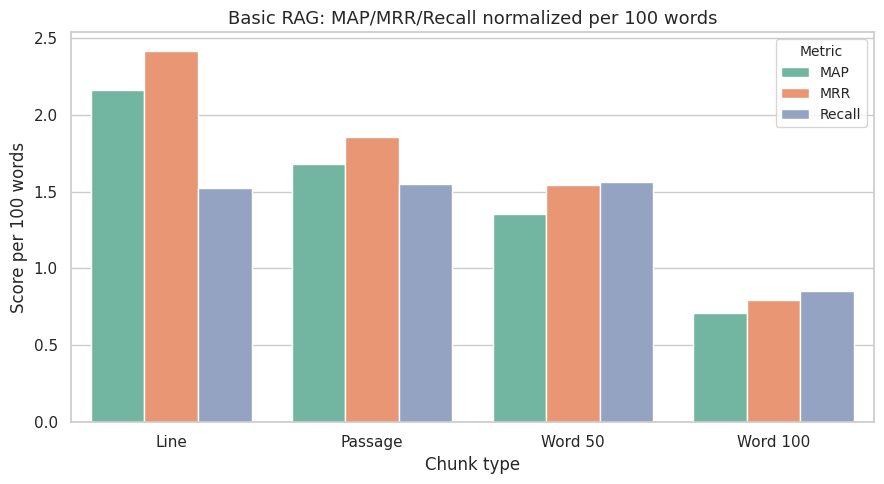

Average words — Line: 31.13, Passage: 40.60


In [6]:
# Normalized Basic RAG metrics per chunk word (line, passage, 50w, 100w)
import os, glob, re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Try to reuse BASE_DIR if it exists, otherwise default to the known run folder
BASE_DIR = globals().get(
    'BASE_DIR',
    "results/retrieval/2025-07-30_09-27-44/QwenQwen3-Embedding-8B"
)
PATTERN = os.path.join(BASE_DIR, "docs_*", "topk_*.pkl")
METRICS = ["map", "mrr", "recall"]

# Utility: robust mean for columns that might contain [x] or scalars
def _mean_col(s: pd.Series) -> float:
    clean = (
        s.dropna()
         .apply(lambda x: x[0] if isinstance(x, (list, tuple)) and len(x) == 1 else x)
         .astype(float)
    )
    return float(clean.mean()) if not clean.empty else np.nan

# Map raw RAG names seen in results to canonical keys
def _canon_rag(name: str) -> str:
    n = (name or "").lower().strip()
    synonyms = {
        "basic": ["basic", "basic_rag", "rag_basic", "retriever_only", "base"],
        "contextual": ["contextual", "document_context", "document_context_rag", "doc_context", "context", "contextual_rag"],
        "hybrid": ["hybrid", "hybrid_rag", "bm25+embed", "fusion", "colbert_hybrid"],
        "random": ["random", "random_rag", "baseline_random"],
    }
    for canon, alts in synonyms.items():
        if n == canon or n in alts:
            return canon
    if "random" in n:
        return "random"
    if "hybrid" in n:
        return "hybrid"
    if "context" in n:
        return "contextual"
    if any(k in n for k in ["basic", "base", "retriever_only"]):
        return "basic"
    return n

# Compute average words for line and passage directly from preprocessed pickles
import re as _re

def _avg_words_from_pickle(pkl_path: str, doc_col: str = "document") -> float:
    try:
        df = pd.read_pickle(pkl_path)
        def _count_words(val) -> int:
            # Accept haystack Document, dict, or raw string
            if hasattr(val, 'content'):
                text = val.content
            elif isinstance(val, dict):
                text = val.get('content', '')
            else:
                text = str(val) if val is not None else ''
            # Tokenize words (unicode letters/digits/underscore)
            return len(_re.findall(r"\w+", text, flags=_re.UNICODE))
        counts = df[doc_col].map(_count_words)
        return float(counts.mean()) if len(counts) else np.nan
    except Exception as e:
        print(f"[warn] Failed to compute avg words from {pkl_path}: {e}")
        return np.nan

avg_line_words = _avg_words_from_pickle("data/preprocessed_documents/docs_line_1_0.pkl")
avg_pass_words = _avg_words_from_pickle("data/preprocessed_documents/docs_passage_1_0.pkl")

# Reasonable fallbacks if not computable
if not np.isfinite(avg_line_words) or avg_line_words <= 0:
    avg_line_words = globals().get('LINE_WORDS', 33)
if not np.isfinite(avg_pass_words) or avg_pass_words <= 0:
    avg_pass_words = globals().get('PASSAGE_WORDS', 35)

# Helper to label the four target chunk strategies from directory names
# e.g., docs_line_1_0, docs_passage_1_0, docs_word_50_10, docs_word_100_20

def _split_label(split_dir: str) -> str | None:
    s = split_dir.replace('docs_', '')
    if s.startswith('line_'):
        return 'Line'
    if s.startswith('passage_'):
        return 'Passage'
    if s.startswith('word_50'):
        return 'Word 50'
    if s.startswith('word_100'):
        return 'Word 100'
    return None

# Load only the files for the four target chunk strategies and all top-k
records = []
for fp in glob.glob(PATTERN):
    split_dir = os.path.basename(os.path.dirname(fp))  # e.g., docs_word_50_10
    label = _split_label(split_dir)
    if label is None:
        continue  # skip other chunk strategies
    m = re.search(r"topk_(\d+)\.pkl$", fp)
    if not m:
        continue
    topk = int(m.group(1))
    try:
        df = pd.read_pickle(fp)
    except Exception as e:
        print(f"[warn] Failed to read {fp}: {e}")
        continue

    # Determine metric prefixes that have all required metric columns
    prefixes = {
        col.rsplit("_", 1)[0]
        for col in df.columns
        if any(col.endswith(f"_{mx}") for mx in METRICS)
    }
    prefixes = sorted(
        p for p in prefixes
        if all(f"{p}_{mx}" in df.columns for mx in METRICS)
    )

    for p in prefixes:
        canon = _canon_rag(p)
        for metric in METRICS:
            col = f"{p}_{metric}"
            score = _mean_col(df[col]) if col in df.columns else np.nan
            records.append({
                "splitting_label": label,
                "topk": topk,
                "rag_type": canon,
                "metric": metric,
                "score": score,
            })

res = pd.DataFrame.from_records(records)
res = res.dropna(subset=["score"]) if not res.empty else res

if res.empty or not (res['rag_type'] == 'basic').any():
    print("[info] No Basic RAG results found for the selected chunk strategies.")
else:
    # Aggregate across all Top-K for Basic only
    basic = (
        res[res['rag_type'] == 'basic']
        .groupby(["splitting_label", "metric"], as_index=False)["score"].mean()
    )

    # Words-per-chunk mapping for normalization
    words_map = {
        'Line': float(avg_line_words),
        'Passage': float(avg_pass_words),
        'Word 50': 50.0,
        'Word 100': 100.0,
    }
    basic["words_per_chunk"] = basic["splitting_label"].map(words_map)

    # Compute score per 100 words for readability
    basic["score_per_100_words"] = (basic["score"] / basic["words_per_chunk"]) * 100.0

    # Pretty labels for metrics
    metric_title = {"map": "MAP", "mrr": "MRR", "recall": "Recall"}
    basic["metric_label"] = basic["metric"].map(metric_title)

    order_chunks = ["Line", "Passage", "Word 50", "Word 100"]
    order_metrics = ["MAP", "MRR", "Recall"]

    plt.figure(figsize=(9, 5))
    sns.set(style="whitegrid")
    ax = sns.barplot(
        data=basic,
        x="splitting_label", y="score_per_100_words", hue="metric_label",
        order=order_chunks, hue_order=order_metrics,
        palette=sns.color_palette("Set2", n_colors=3)
    )
    ax.set_xlabel("Chunk type", fontsize=12)
    ax.set_ylabel("Score per 100 words", fontsize=12)
    ax.set_title("Basic RAG: MAP/MRR/Recall normalized per 100 words", fontsize=13)
    ax.legend(title="Metric", fontsize=10, title_fontsize=10)
    plt.tight_layout()
    plt.show()

    print(f"Average words — Line: {avg_line_words:.2f}, Passage: {avg_pass_words:.2f}")